# When Do Different Types of Collisions Occur?

Understanding when the different types of collisions occur can help determine the cause of collisions and suggest possible mitigations to reduce collisions, injuries, and deaths.

### Definitions
- __Collision:__ A motor vehicle collision involving injuries, deaths, or a significant amount of property damage (~> $1000) reported on a New York State form, MV104-AN
- __Serious Collision:__ A collision where at least one person is injured or killed

### Data Sources
- Collision data is from the New York Police Department (NYPD) NYC Collisions dataset.
    - https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
- Collision data was processed by running `process_raw.data.py` which saves processed data to local directory specified in `process_raw.data.py` script
- Traffic index was created in 2-preparing-mta-data-xgboost.ipynb notebook using Metropolitan Transit Authority (MTA) Bridge and Tunnel toll data.
    - https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga/about_data
- Bicycle Index was created in 1c-profiling-nyc-bike-counter-data.ipynb using the NYC Bicycle Counts dataset.
    - https://data.cityofnewyork.us/Transportation/Bicycle-Counts/uczf-rk3c/about_data


In [1]:
import os.path
import matplotlib as mpl
import pandas as pd
import src.strings
from src.constants import DAY_OF_WEEK_MAP, MONTHS_MAP, SEASONS
import src.utils
from src import visualizations as viz

# Parameters 

In [2]:
PROCESSED_CRASH_DATA = "data/processed/crashes.pkl"
MTA_CROSSINGS_DATA = "data/processed/traffic_index.pkl"
BIKE_INDEX = "data/processed/nyc_bike_counts.pkl"
IMG_DIR = "output"
START_YEAR = 2013
END_YEAR = 2023
MILLION = 1000000
NOTE = "Calculated based\non data since 2015"

# Helper Functions

In [3]:
def collision_groupby(df, groupby_arr, divisor=1):
    """Return a pd.DataFrame of groupby collision aggregates."""
    ret_df = pd.DataFrame()
    ret_df["Serious Collisions"] = (
        df.groupby(by=groupby_arr, observed=False)["serious"].sum() / divisor
    )
    ret_df["Pedestrian Collisions"] = (
        df.groupby(by=groupby_arr, observed=False)["pedestrian"].sum() / divisor
    )
    ret_df["Cyclist Collisions"] = (
        df.groupby(by=groupby_arr, observed=False)["cyclist"].sum() / divisor
    )
    return ret_df

# Data Preparation

__Loading datasets__

In [4]:
crashes = pd.read_pickle(PROCESSED_CRASH_DATA)
mta_crossings = pd.read_pickle(MTA_CROSSINGS_DATA)
bike_index = pd.read_pickle(BIKE_INDEX)

__Selecting date range__

In [5]:
crashes = crashes[(START_YEAR <= crashes.index.year) & (crashes.index.year <= END_YEAR)]
mta_crossings = mta_crossings[
    (START_YEAR <= mta_crossings.index.year) & (mta_crossings.index.year <= END_YEAR)
]
bike_index = bike_index[
    (START_YEAR <= bike_index.index.year) & (bike_index.index.year <= END_YEAR)
]
crashes.index.min(), crashes.index.max()

(Timestamp('2013-01-01 00:01:00'), Timestamp('2023-12-31 23:18:00'))

__Creating dataframes / views that will be used for analysis__

Analysis will focus on collisions resulting in injuries or deaths. The reporting of collisions without injuries or deaths is less consistent and will not be used in analysis.

In [6]:
serious = crashes[crashes["serious"]].copy()

Creating view of crashes from 2015 onward to use with index of cycling activity

In [7]:
serious15 = crashes[(crashes["serious"]) & (crashes.index.year >= 2015)].copy()
serious15.index.min(), serious15.index.max()

(Timestamp('2015-01-01 00:20:00'), Timestamp('2023-12-31 22:27:00'))

__Adding season attribute to indices based on datetime index__

In [8]:
mta_crossings["season"] = mta_crossings.index.map(src.utils.date_to_season)
bike_index["season"] = bike_index.index.map(src.utils.date_to_season)

__Calculating time-related values for scaling values__

In [9]:
timerange = serious.index.max() - serious.index.min()  # Pandas Timedelta object
total_days = timerange.round("1d").days
total_years = total_days / 365.25
total_weeks = total_days / 7
total_weeks_ex_17 = (total_days - 365) / 7

# What are overall trends in collisions over the last few years? 

## Serious Collisions
- From 2013 to 2019 there were:
    - Between 37k and 46k collisions per year that injured or killed at least one person, an __average of ~100 to ~120 a day__
    - Between 14k and 16k collisions per year that injured or killed at least one pedestrians or cyclist, an __average of ~38 to ~44 a day__
- Serious collisions trended upwards from 2013 to 2019 while collisions with pedestrians and cyclists was approximately flat
- Serious collisions and collisions with pedestrians and cyclists dropped sharply in 2020 (presumably due to COVID) but have been trending upwards since then

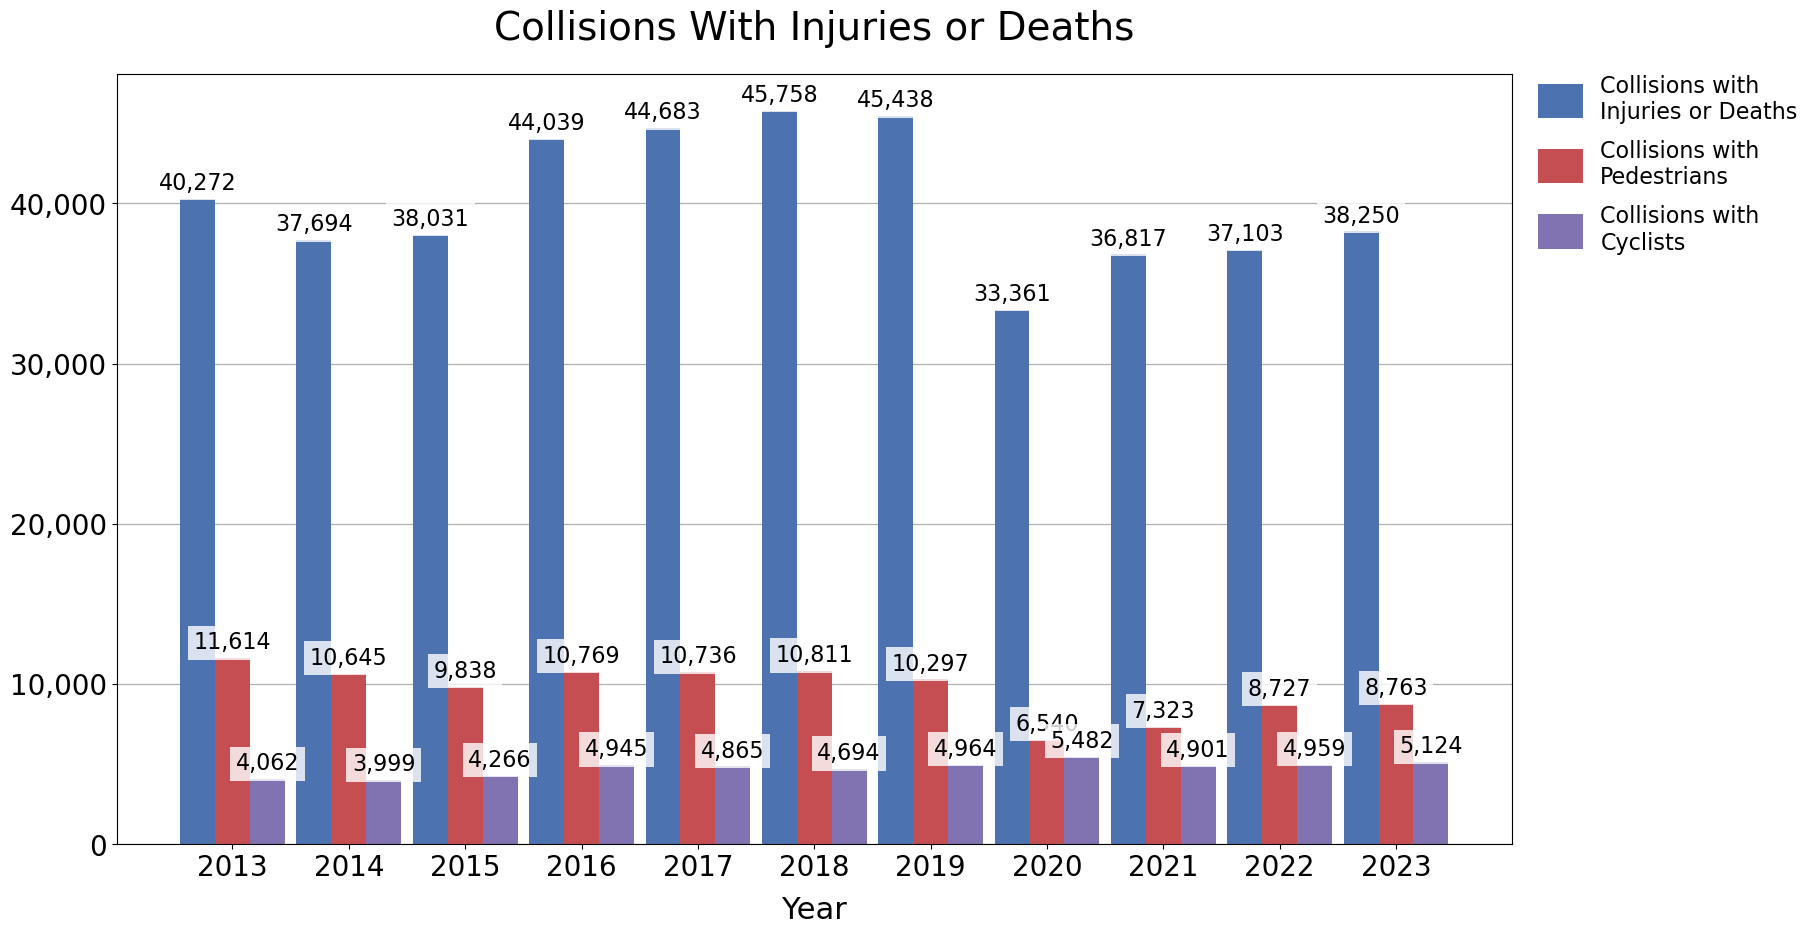

In [10]:
year_groupby = collision_groupby(serious, serious.index.year)
groups = [
    "Collisions with Injuries or Deaths",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.grouped_bar_chart(
    year_groupby,
    title="Collisions With Injuries or Deaths",
    xlabel="Year",
    yaxis_format="{x:,.0f}",
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_handleheight": 2.0, "legend_bbox": (1.07, 0.9)},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "yearly_collisions.png"),
)

## Serious Collisions Adjusting for Vehicle Activity
Normalizing collisions by millions of MTA bridge and tunnel crossings, a proxy for vehicle activity

- The number of serious collisions and collisions involving pedestrians and cyclists relative to driving activity appears to be trending downwards. This could indicate that efforts to improve road safety are working
- These results may also reflect changing driving patterns with traffic being shifted to the major roadways controlled by the MTA

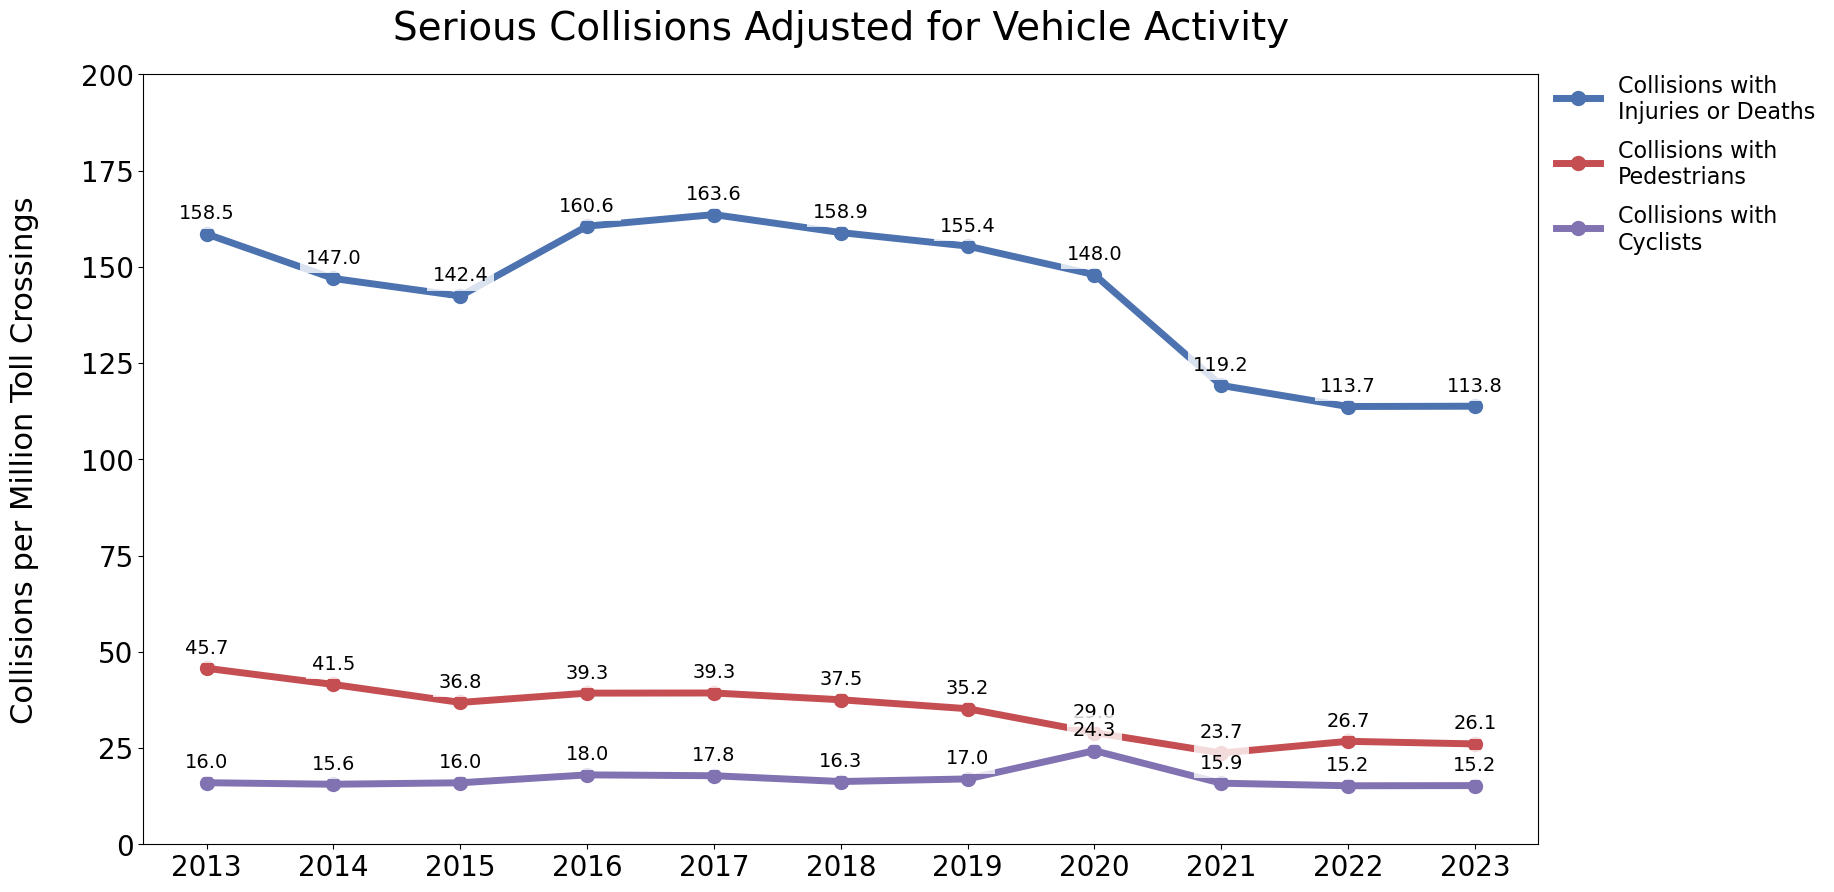

In [11]:
annual_mta_crossings = (
    mta_crossings.groupby(by=mta_crossings.index.year)["Sum Vehicles"].sum() / MILLION
)
normalized = year_groupby.divide(annual_mta_crossings, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["Serious Collisions"]),
    (normalized.index.values, normalized["Pedestrian Collisions"]),
    (normalized.index.values, normalized["Cyclist Collisions"]),
]
groups = [
    "Collisions with Injuries or Deaths",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.line_chart(
    data_to_plot,
    title="Serious Collisions Adjusted for Vehicle Activity",
    ylabel="Collisions per Million Toll Crossings",
    ylabel_rotation="vertical",
    ylim=(0, 200),
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8}
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.065, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "yearly_collisions_norm_vehicle.png"),
)

## Collisions with Cyclists Adjusted for Cycling Activity

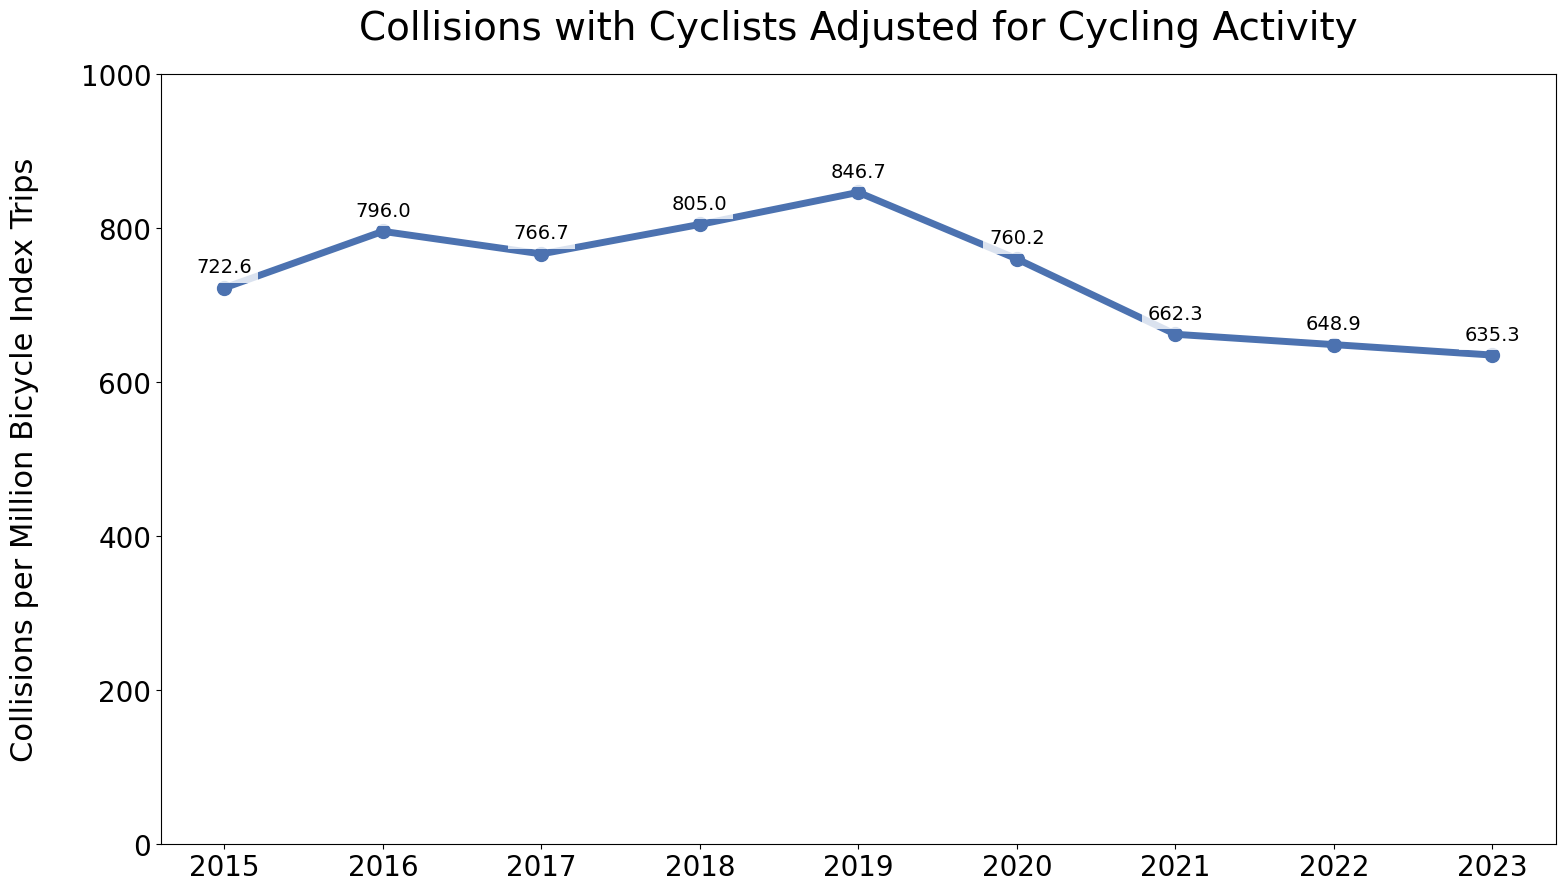

In [12]:
annual_bike_index = (
    bike_index.groupby(by=bike_index.index.year)["NYC Bicycle Counts"].sum() / MILLION
)
year_gte15 = year_groupby[year_groupby.index >= 2015]
normalized = year_gte15.divide(annual_bike_index, axis=0)
data_to_plot = [(normalized.index.values, normalized["Cyclist Collisions"])]
groups = ["Collisions with Cyclists"]
viz.line_chart(
    data_to_plot,
    title="Collisions with Cyclists Adjusted for Cycling Activity",
    ylabel="Collisions per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1000),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8}
    },
    save=os.path.join(IMG_DIR, "trends", "yearly_collisions_norm_bicycle.png"),
)

## Injuries and Deaths

#### Overall Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 51k and 62k injuries per year, an __average of ~140 to ~170 a day__
    - __Between 230 and 300 people killed in collisions each year__
- Total injuries trended upwards from 2013 to 2019
- Total injuries in 2021-2023 were ~15% lower than 2018 / 2019 levels
- Fatalities from 2021-2023 were elevated

#### Pedestrian / Cyclist (Non-Motorist) Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 14k and 16k pedestrians and cyclists injured per year, an __average of ~38 to ~44 a day__
    - __Between 130 and 190 pedestrians and cyclists killed in collisions each year__
- Total pedestrian and cyclist injuries were approximately flat from 2013 to 2019
- Pedestrian and cyclist injuries dropped in 2020 but have been trending upwards

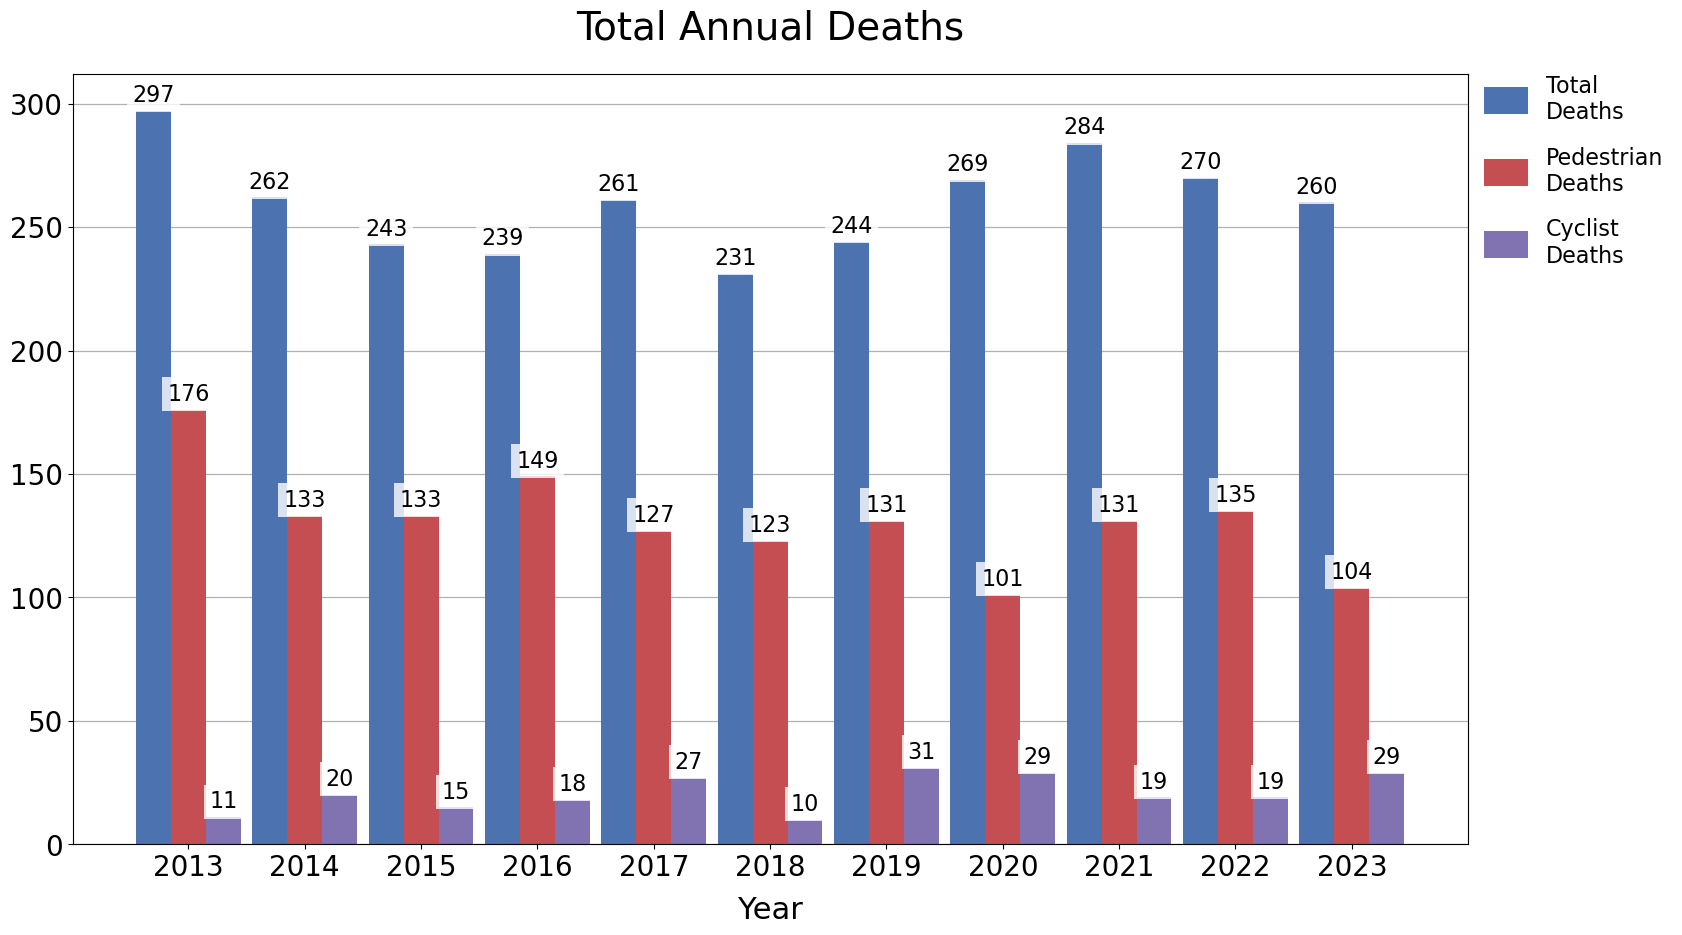

In [13]:
fields = [
    "KILLED",
    "PEDESTRIAN KILLED",
    "CYCLIST KILLED",
]
deaths = serious.groupby(by=serious.index.year)[fields].sum()
labels = {
    "title": "Total Annual Deaths",
    "xlabel": "Year",
}
groups = [
    "Total Deaths",
    "Pedestrian Deaths",
    "Cyclist Deaths",
]
viz.grouped_bar_chart(
    deaths,
    **labels,
    legend_labels=src.strings.add_line_breaks(groups),
    minor_ticks=False,
    ylabel_rotation="vertical",
    ylabel_pad=10,
    yaxis_format="{x:,.0f}",
    legend_args={"legend_bbox": (1.02, 0.9), "legend_labelspacing": 1.0},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "yearly_deaths.png"),
)

## Deaths Adjusted for Vehicle Activity
- Normalized injuries have been trending downwards since 2020
- Pedestrians and cyclist injuries have also been trending downwards since 2020 adjusting for vehicle activity. This however may just reflect reduced pedestrian and cycling traffic
- Deaths adjusted for vehicle activity spiked in 2020 and have returned to the recent historical average
- Pedestrians and cyclist deaths appear to be tranding downwards since 2020 but once again may just reflect reduced pedestrian and cycling traffic

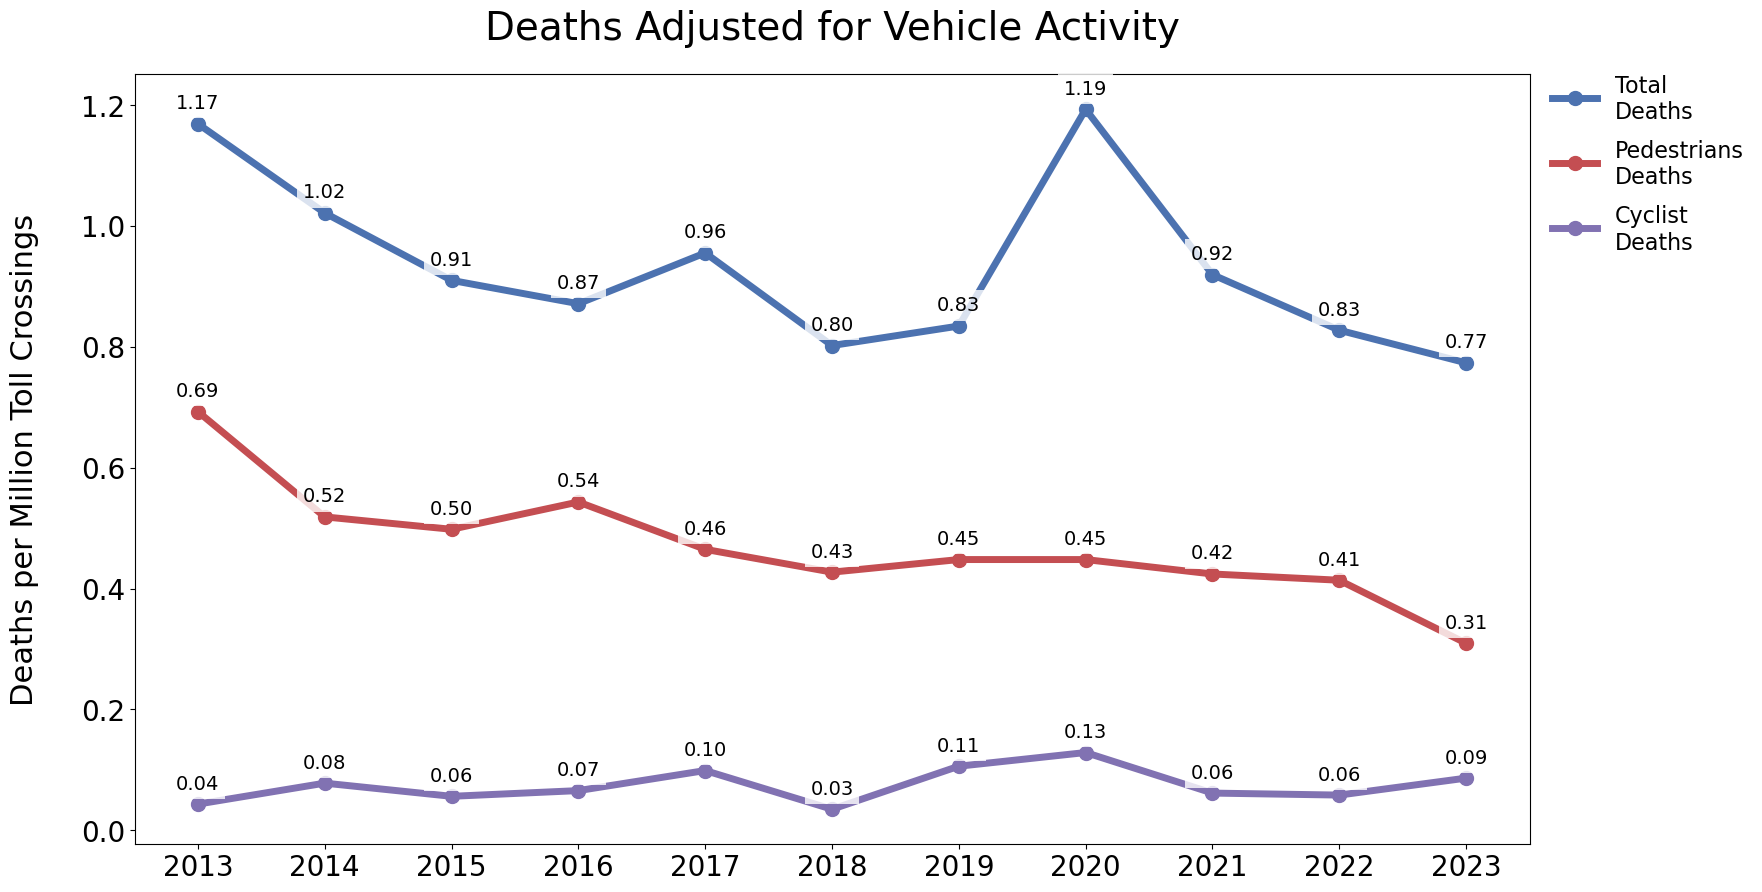

In [14]:
normalized = deaths.divide(annual_mta_crossings, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["KILLED"]),
    (normalized.index.values, normalized["PEDESTRIAN KILLED"]),
    (normalized.index.values, normalized["CYCLIST KILLED"]),
]
groups = [
    "Total Deaths",
    "Pedestrians Deaths",
    "Cyclist Deaths",
]
viz.line_chart(
    data_to_plot,
    title="Deaths Adjusted for Vehicle Activity",
    ylabel="Deaths per Million Toll Crossings",
    ylabel_rotation="vertical",
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.03, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "yearly_deaths_norm_vehicle.png"),
)

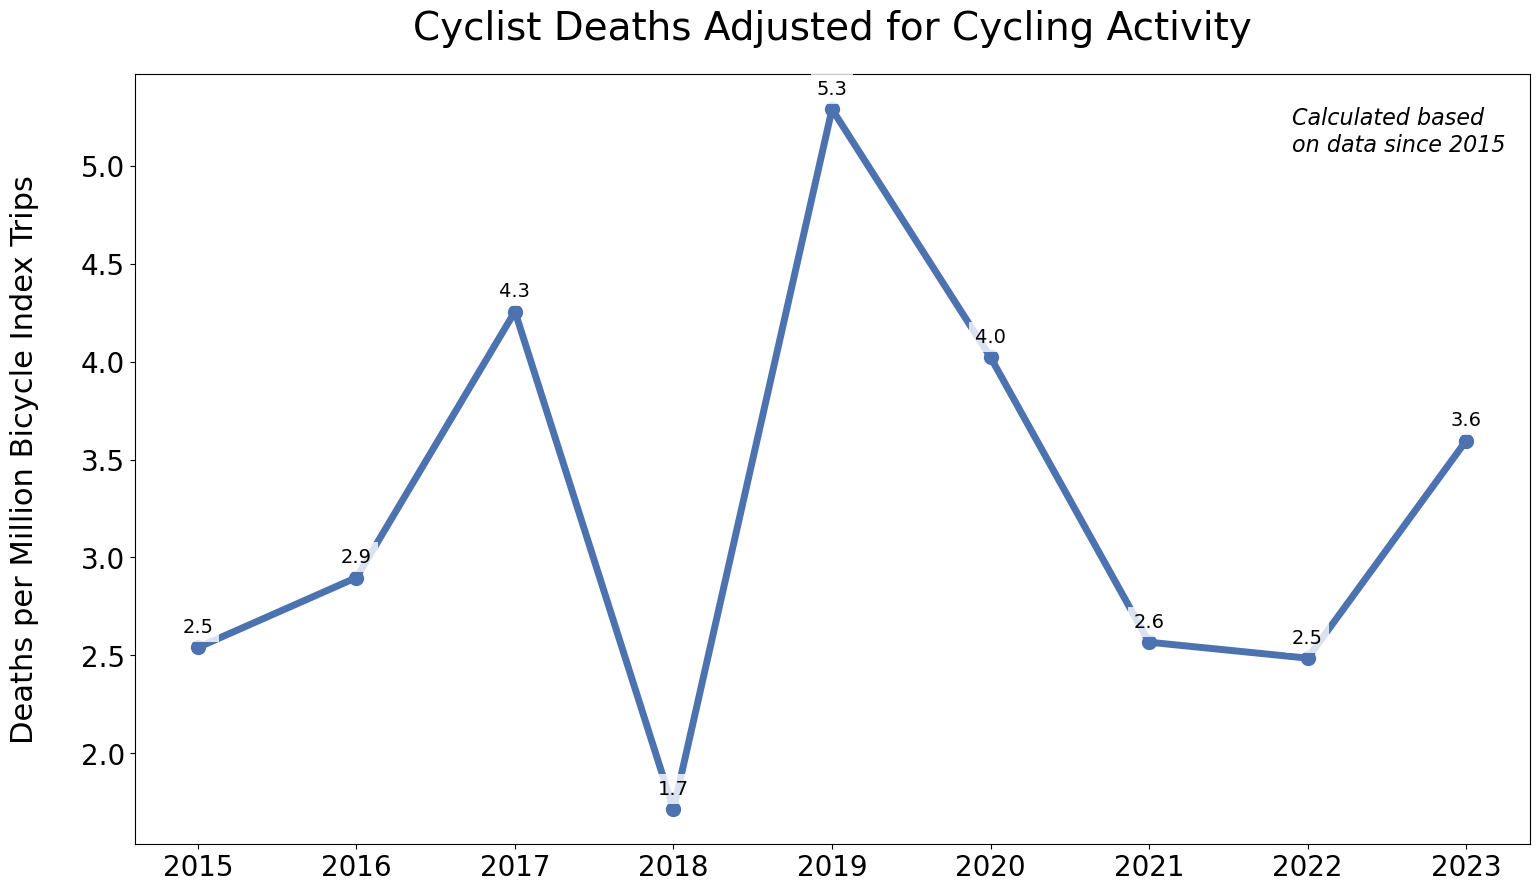

In [15]:
year_gte15 = deaths[deaths.index >= 2015]
normalized = year_gte15.divide(annual_bike_index, axis=0)
data_to_plot = [(normalized.index.values, normalized["CYCLIST KILLED"])]
groups = ["Cyclist Deaths"]
viz.line_chart(
    data_to_plot,
    title="Cyclist Deaths Adjusted for Cycling Activity",
    ylabel="Deaths per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8}
    },
    text=[0.83, 0.9, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "yearly_deaths_norm_bicycle.png"),
)

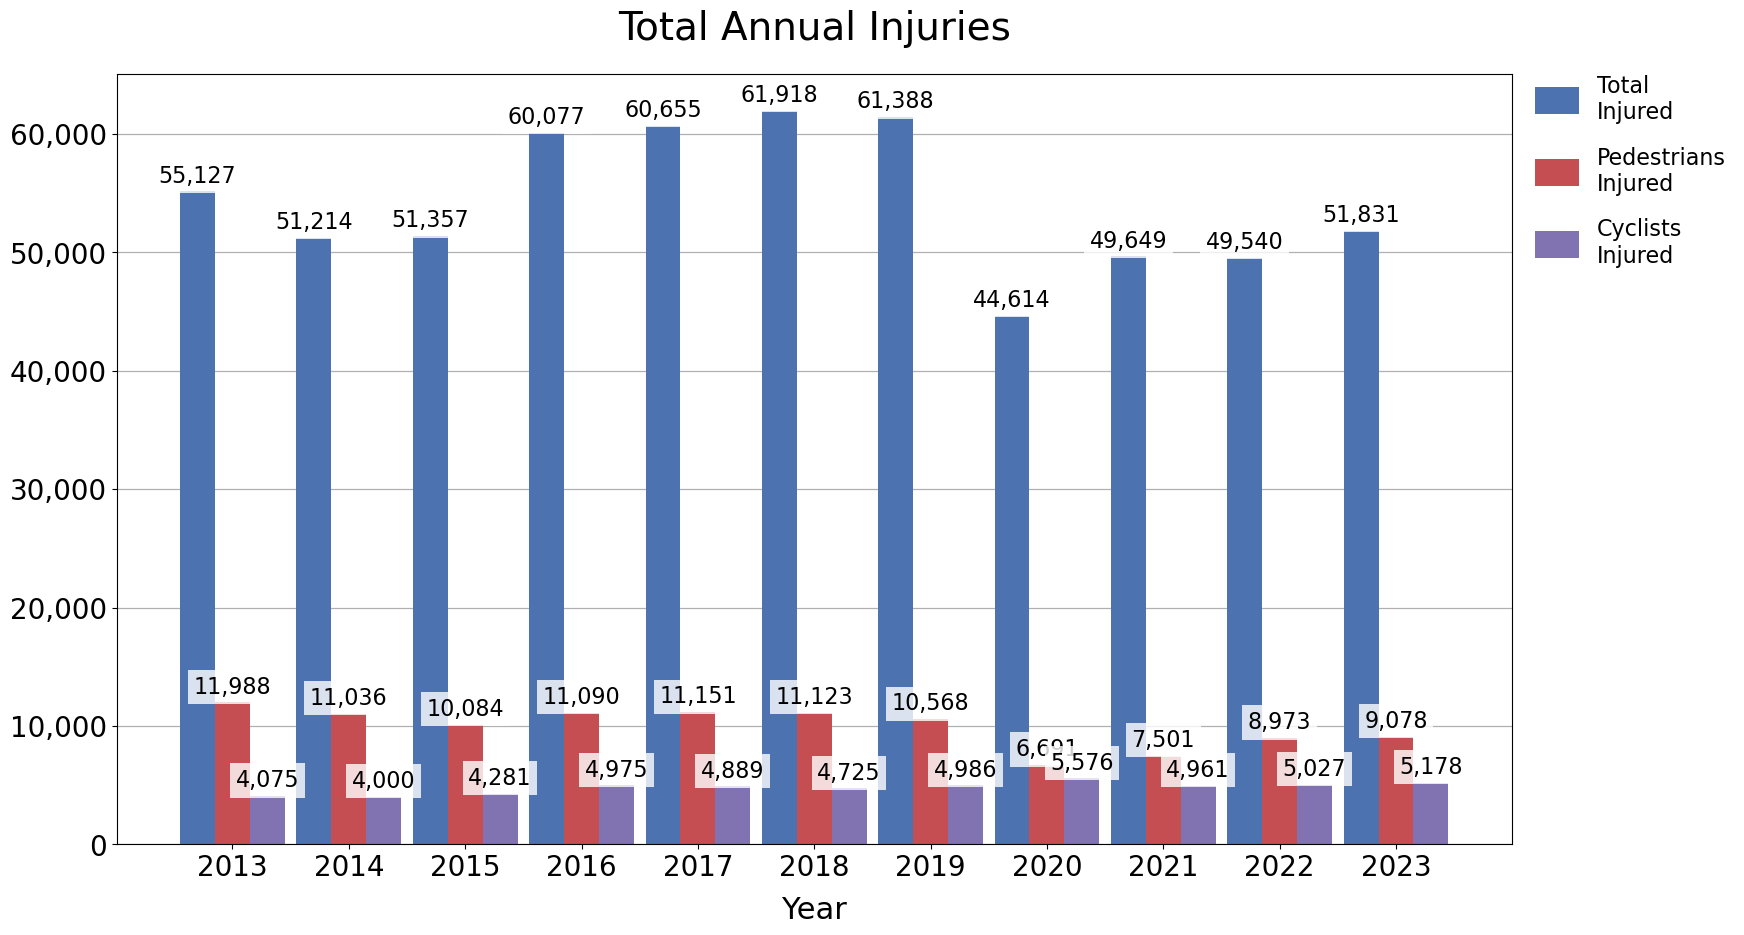

In [16]:
fields = [
    "INJURED",
    "PEDESTRIAN INJURED",
    "CYCLIST INJURED",
]
injuries = serious.groupby(by=serious.index.year)[fields].sum()
groups = [
    "Total Injured",
    "Pedestrians Injured",
    "Cyclists Injured",
]
viz.grouped_bar_chart(
    injuries,
    title="Total Annual Injuries",
    xlabel="Year",
    legend_labels=src.strings.add_line_breaks(groups),
    minor_ticks=False,
    ylabel_rotation="vertical",
    ylabel_pad=10,
    yaxis_format="{x:,.0f}",
    legend_args={"legend_bbox": (1.03, 0.9), "legend_labelspacing": 1.0},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "yearly_injuries.png"),
)

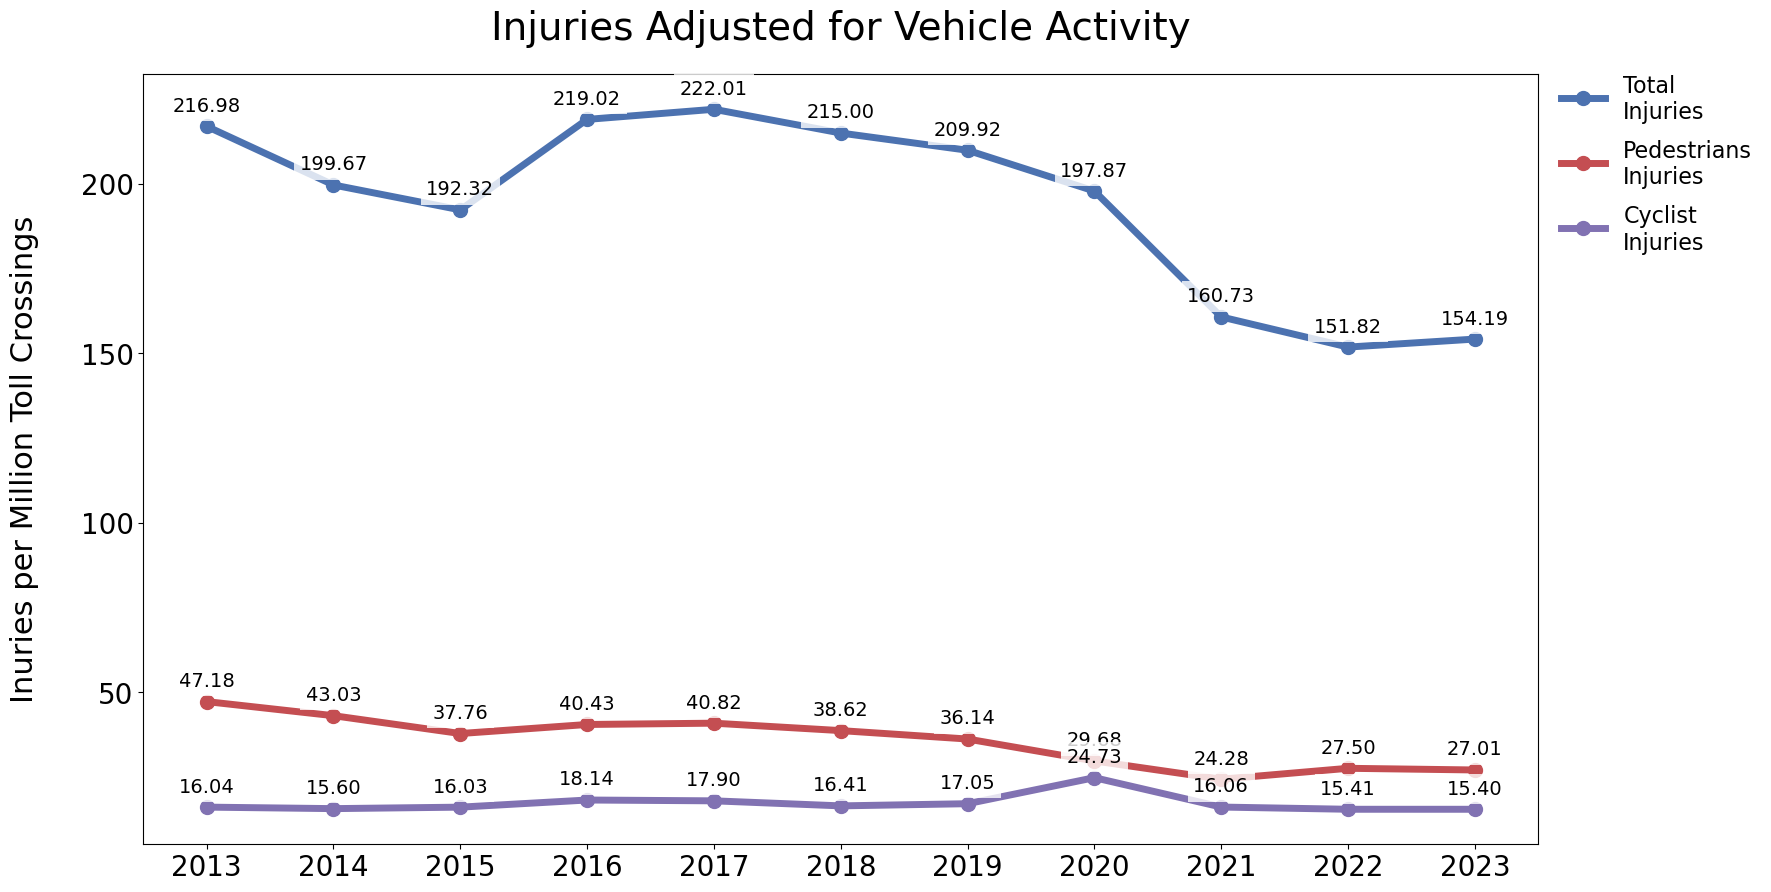

In [17]:
normalized = injuries.divide(annual_mta_crossings, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["INJURED"]),
    (normalized.index.values, normalized["PEDESTRIAN INJURED"]),
    (normalized.index.values, normalized["CYCLIST INJURED"]),
]
groups = [
    "Total Injuries",
    "Pedestrians Injuries",
    "Cyclist Injuries",
]
viz.line_chart(
    data_to_plot,
    title="Injuries Adjusted for Vehicle Activity",
    ylabel="Inuries per Million Toll Crossings",
    ylabel_rotation="vertical",
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.03, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "yearly_injury_norm_vehicle.png"),
)

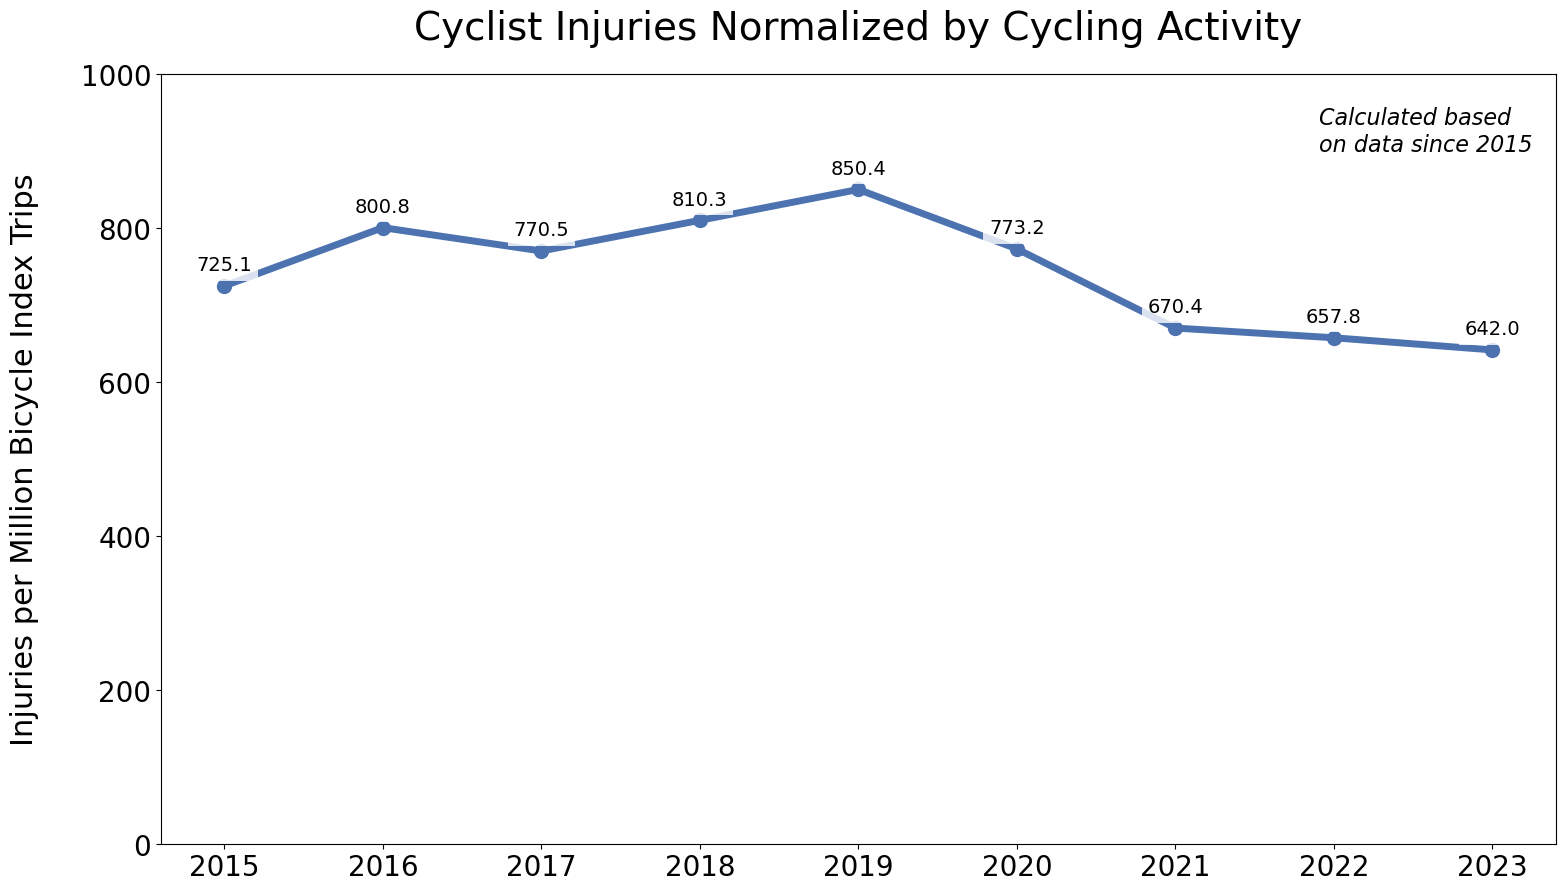

In [18]:
year_gte15 = injuries[injuries.index >= 2015]
normalized = year_gte15.divide(annual_bike_index, axis=0)
data_to_plot = [(normalized.index.values, normalized["CYCLIST INJURED"])]
groups = ["Cyclist Injuries"]
viz.line_chart(
    data_to_plot,
    title="Cyclist Injuries Normalized by Cycling Activity",
    ylabel="Injuries per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1000),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8}
    },
    text=[0.83, 0.9, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "yearly_injuries_norm_bike.png"),
)

# 1D views on when collisions are most common

## Seasonal Variation

- Summer tends to have the most serious collisions
- Fall tends to have the most collisions with pedestrians and cyclists

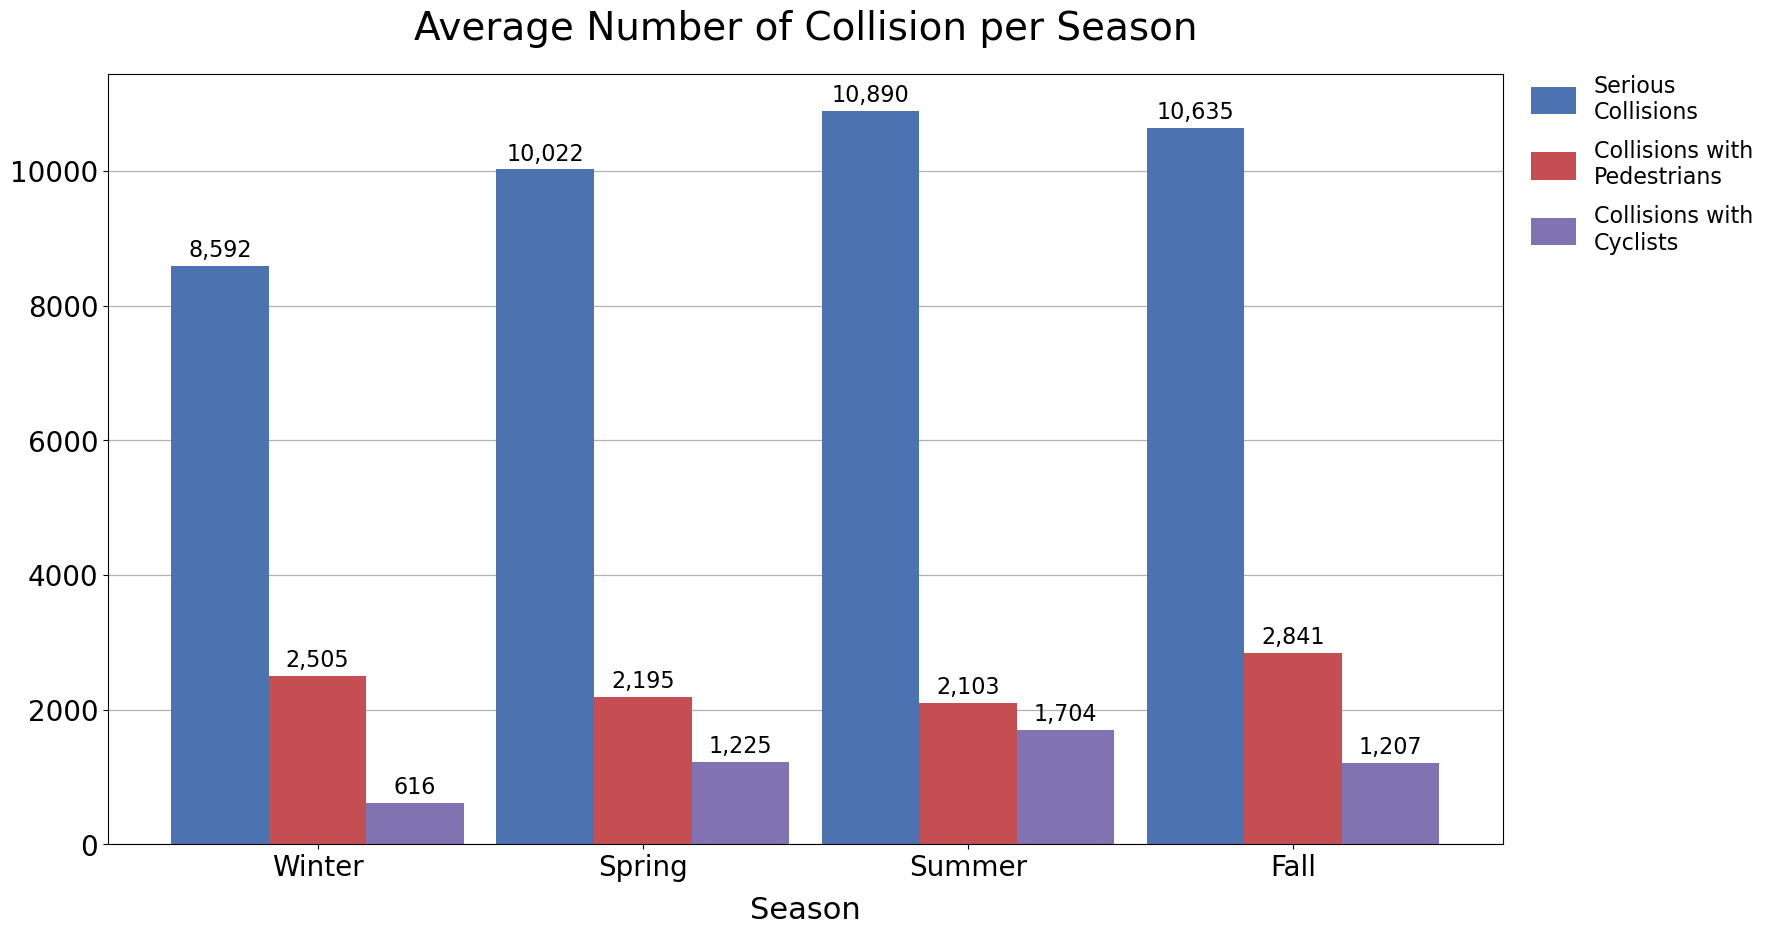

In [19]:
season_groupby = collision_groupby(serious, "season")
season_groupby = season_groupby.reindex(["Winter", "Spring", "Summer", "Fall"])
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.grouped_bar_chart(
    season_groupby / total_years,
    title="Average Number of Collision per Season",
    xlabel="Season",
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.05, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "seasonal.png"),
)

## Normalized Seasonal Variation

- Serious and pedestrian collisions per million toll crossings are highest in Fall

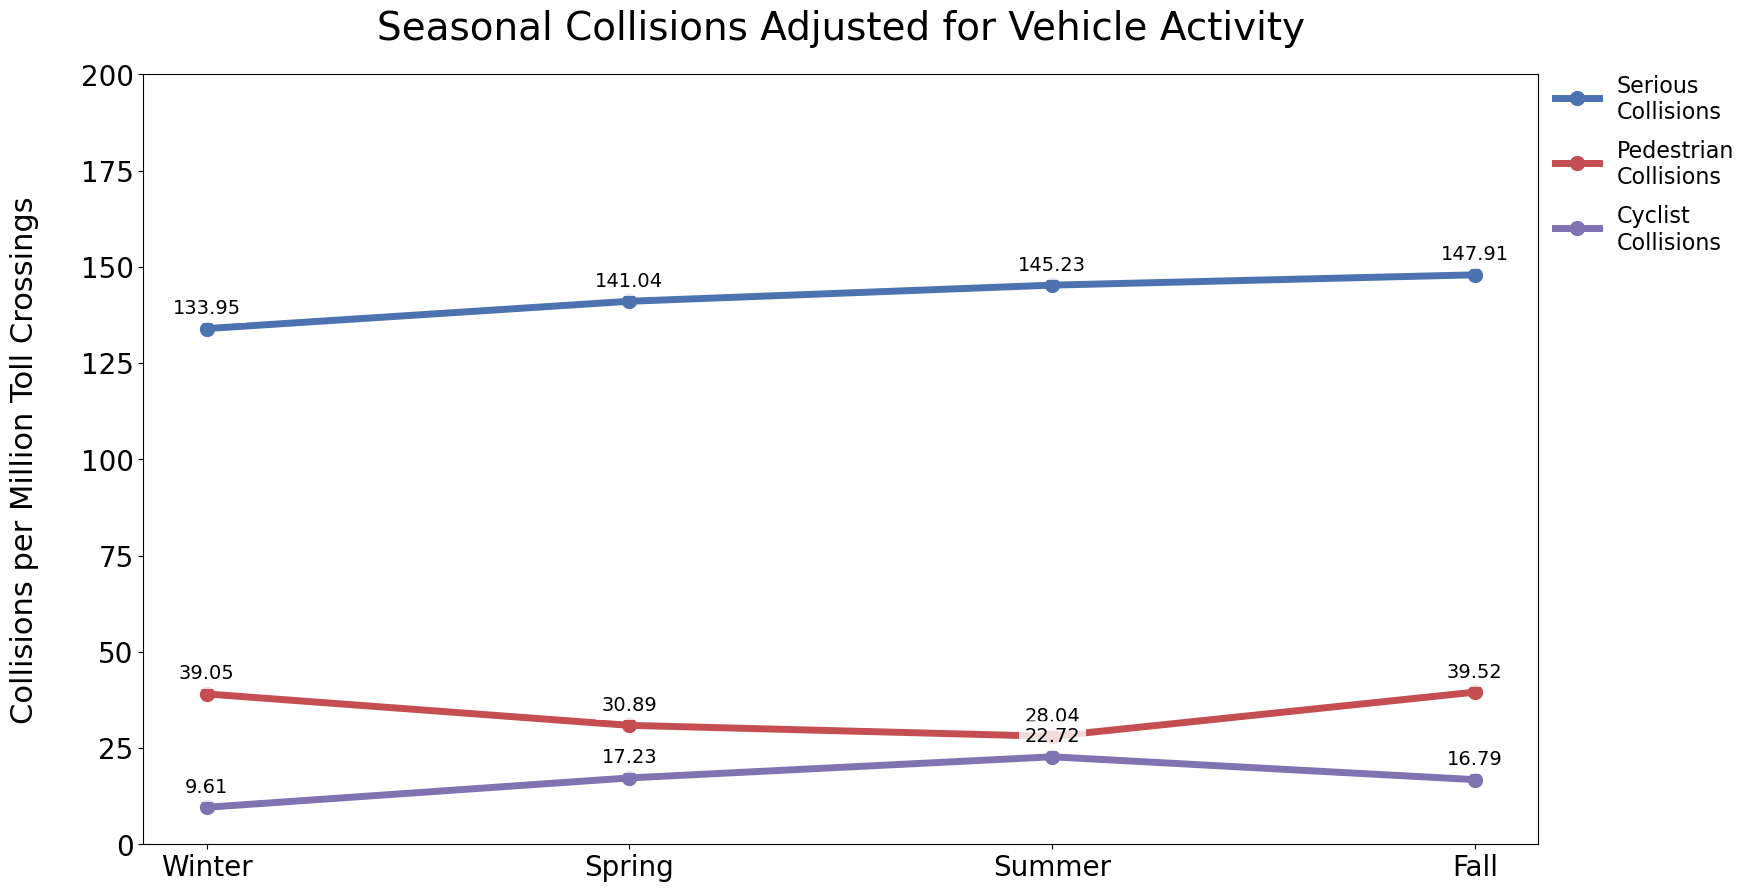

In [20]:
mta_groupby = (
    mta_crossings.groupby(by=mta_crossings["season"])["Sum Vehicles"].sum() / MILLION
)
normalized = season_groupby.divide(mta_groupby, axis=0)
normalized = normalized.reindex(["Winter", "Spring", "Summer", "Fall"])
data_to_plot = [
    (normalized.index.values, normalized["Serious Collisions"]),
    (normalized.index.values, normalized["Pedestrian Collisions"]),
    (normalized.index.values, normalized["Cyclist Collisions"]),
]
groups = [
    "Serious Collisions",
    "Pedestrian Collisions",
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    title="Seasonal Collisions Adjusted for Vehicle Activity",
    ylabel="Collisions per Million Toll Crossings",
    ylabel_rotation="vertical",
    ylim=(0, 200),
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.02, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "season_norm_vehicle.png"),
)

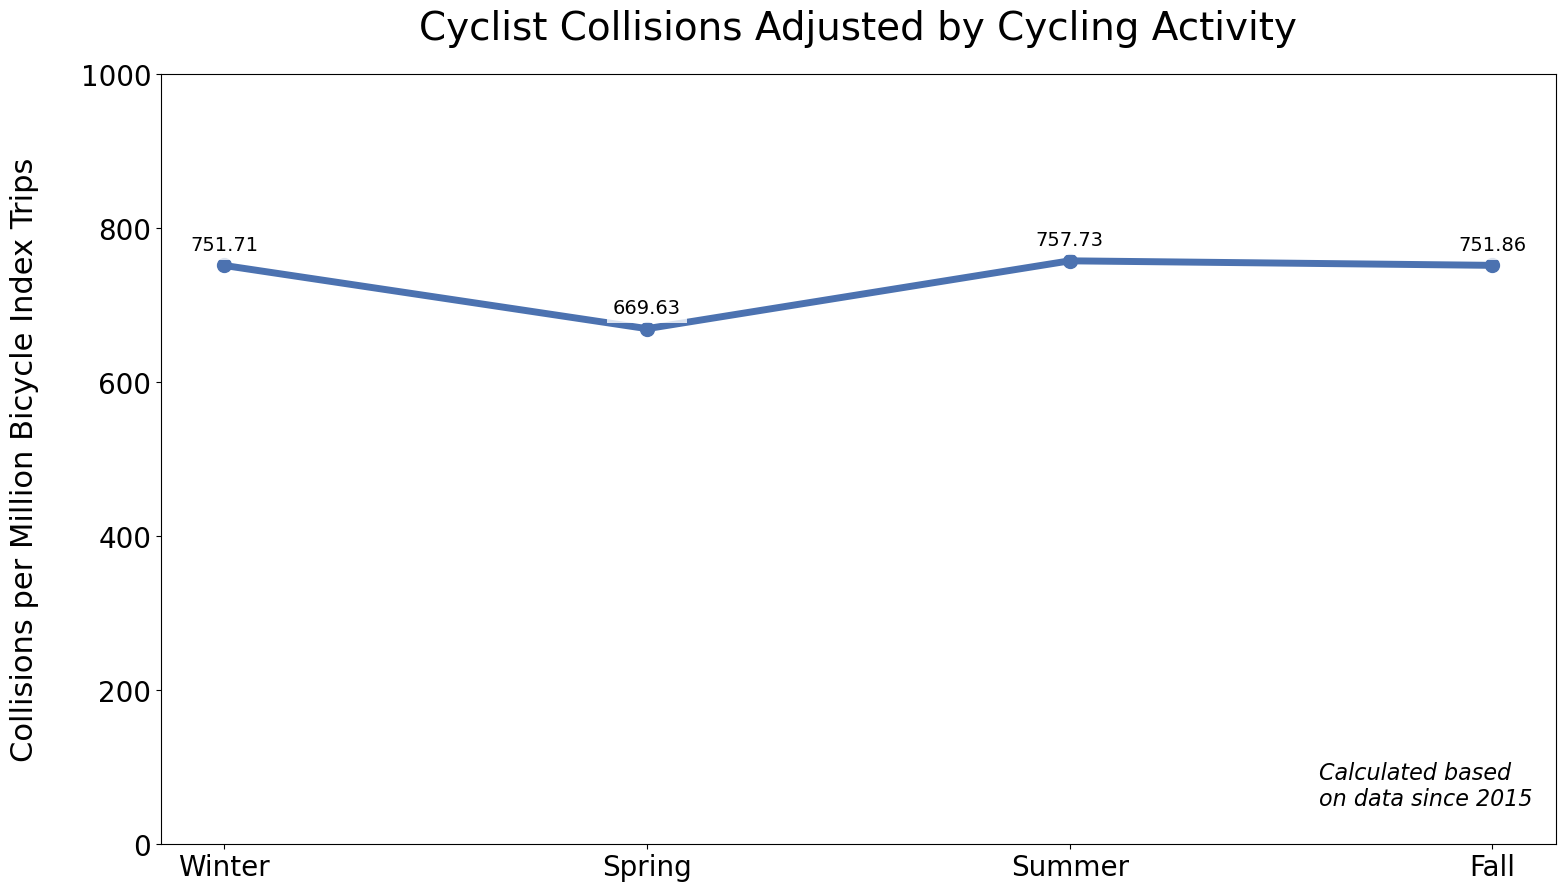

In [21]:
season_groupby = collision_groupby(serious15, "season")
bike_groupby = (
    bike_index.groupby(by=bike_index["season"])["NYC Bicycle Counts"].sum() / MILLION
)
normalized = season_groupby.divide(bike_groupby, axis=0)
normalized = normalized.reindex(["Winter", "Spring", "Summer", "Fall"])
data_to_plot = [(normalized.index.values, normalized["Cyclist Collisions"])]
groups = [
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    title="Cyclist Collisions Adjusted by Cycling Activity",
    ylabel="Collisions per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1000),
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    text=[0.83, 0.05, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "season_norm_bike.png"),
)

## Monthly Variation

- Serious collisions are particularly elevated from May to October
- Collisions with Pedestrians or Cyclists seem to peak in October

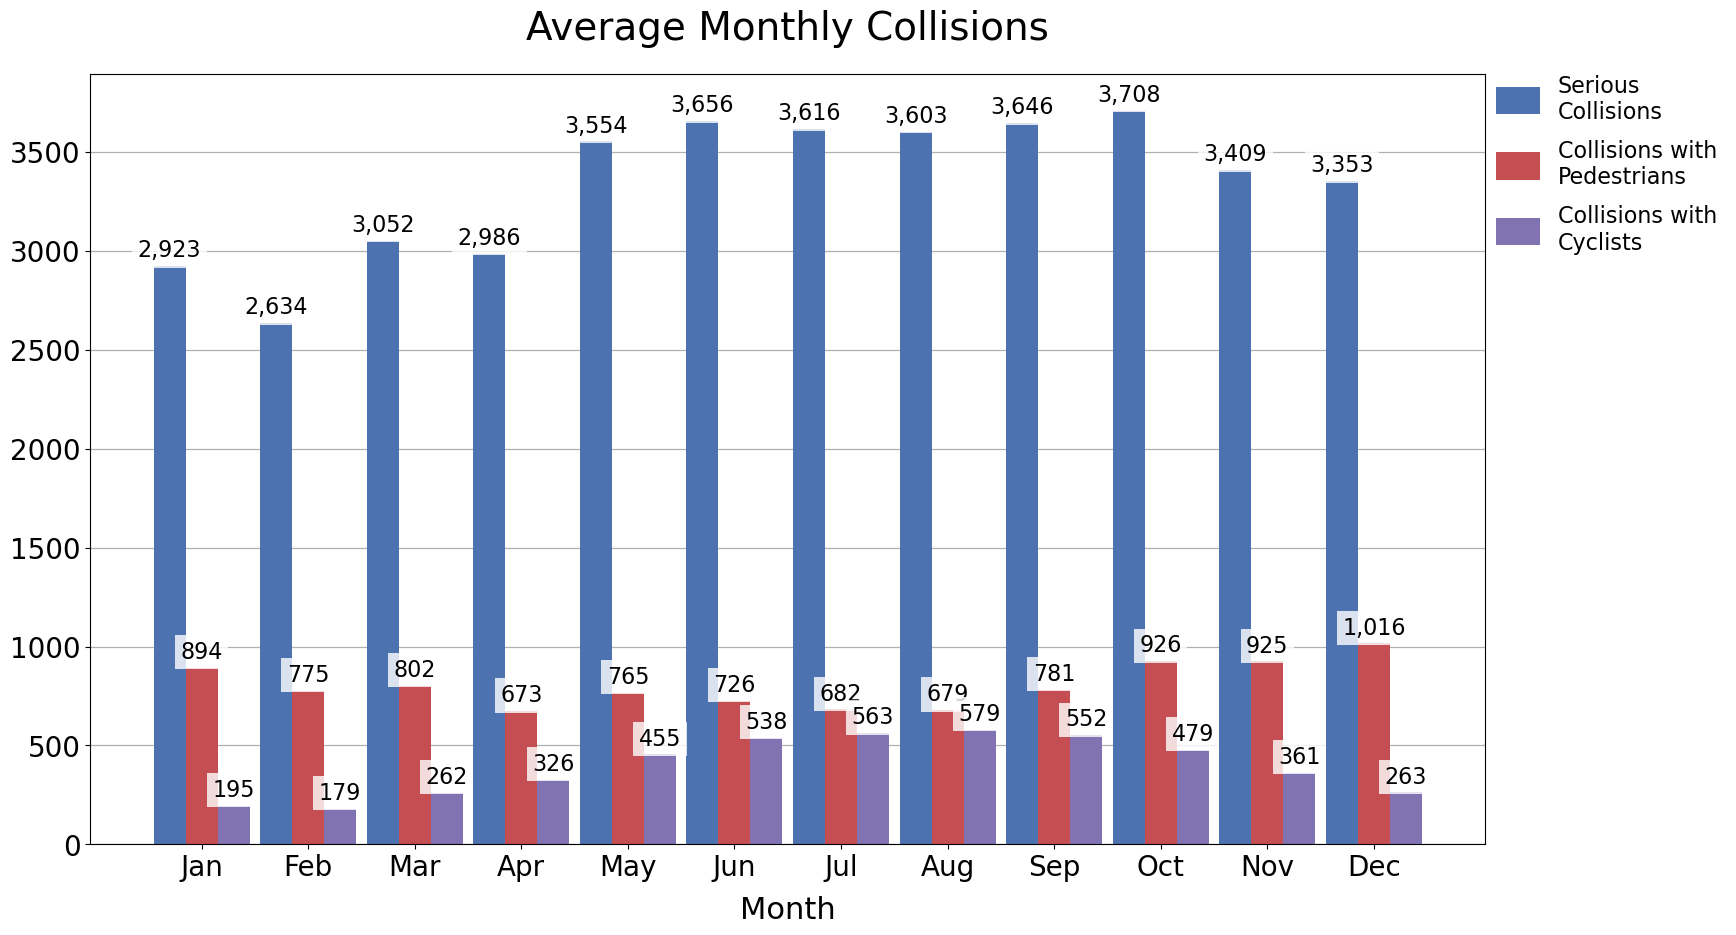

In [22]:
month_groupby = collision_groupby(serious, serious.index.month)
month_groupby.index = month_groupby.index.map(MONTHS_MAP)
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.grouped_bar_chart(
    month_groupby / total_years,
    title="Average Monthly Collisions",
    xlabel="Month",
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.04, 0.9)},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "monthly.png"),
)

## Normalized Monthly Variation 

- Normalized collisions are particularly elevated from May to October

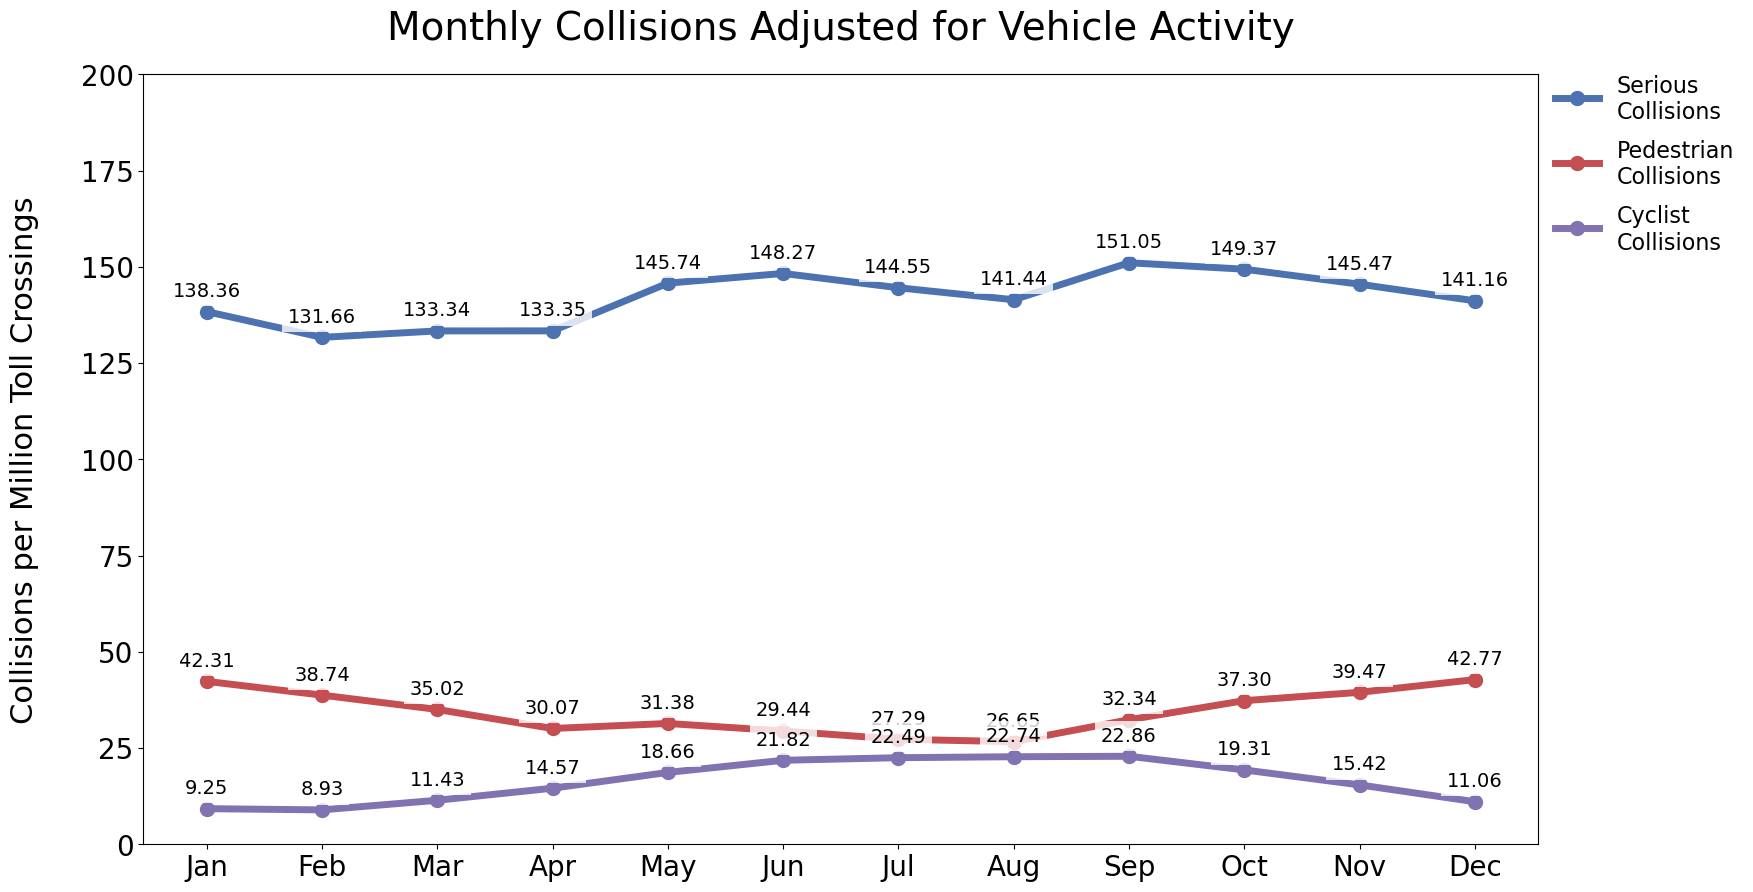

In [23]:
mta_groupby = (
    mta_crossings.groupby(by=mta_crossings.index.month)["Sum Vehicles"].sum() / MILLION
)
mta_groupby.index = mta_groupby.index.map(MONTHS_MAP)
normalized = month_groupby.divide(mta_groupby, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["Serious Collisions"]),
    (normalized.index.values, normalized["Pedestrian Collisions"]),
    (normalized.index.values, normalized["Cyclist Collisions"]),
]
groups = [
    "Serious Collisions",
    "Pedestrian Collisions",
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    title="Monthly Collisions Adjusted for Vehicle Activity",
    ylabel="Collisions per Million Toll Crossings",
    ylabel_rotation="vertical",
    ylim=(0, 200),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.02, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "month_norm_vehicle.png"),
)

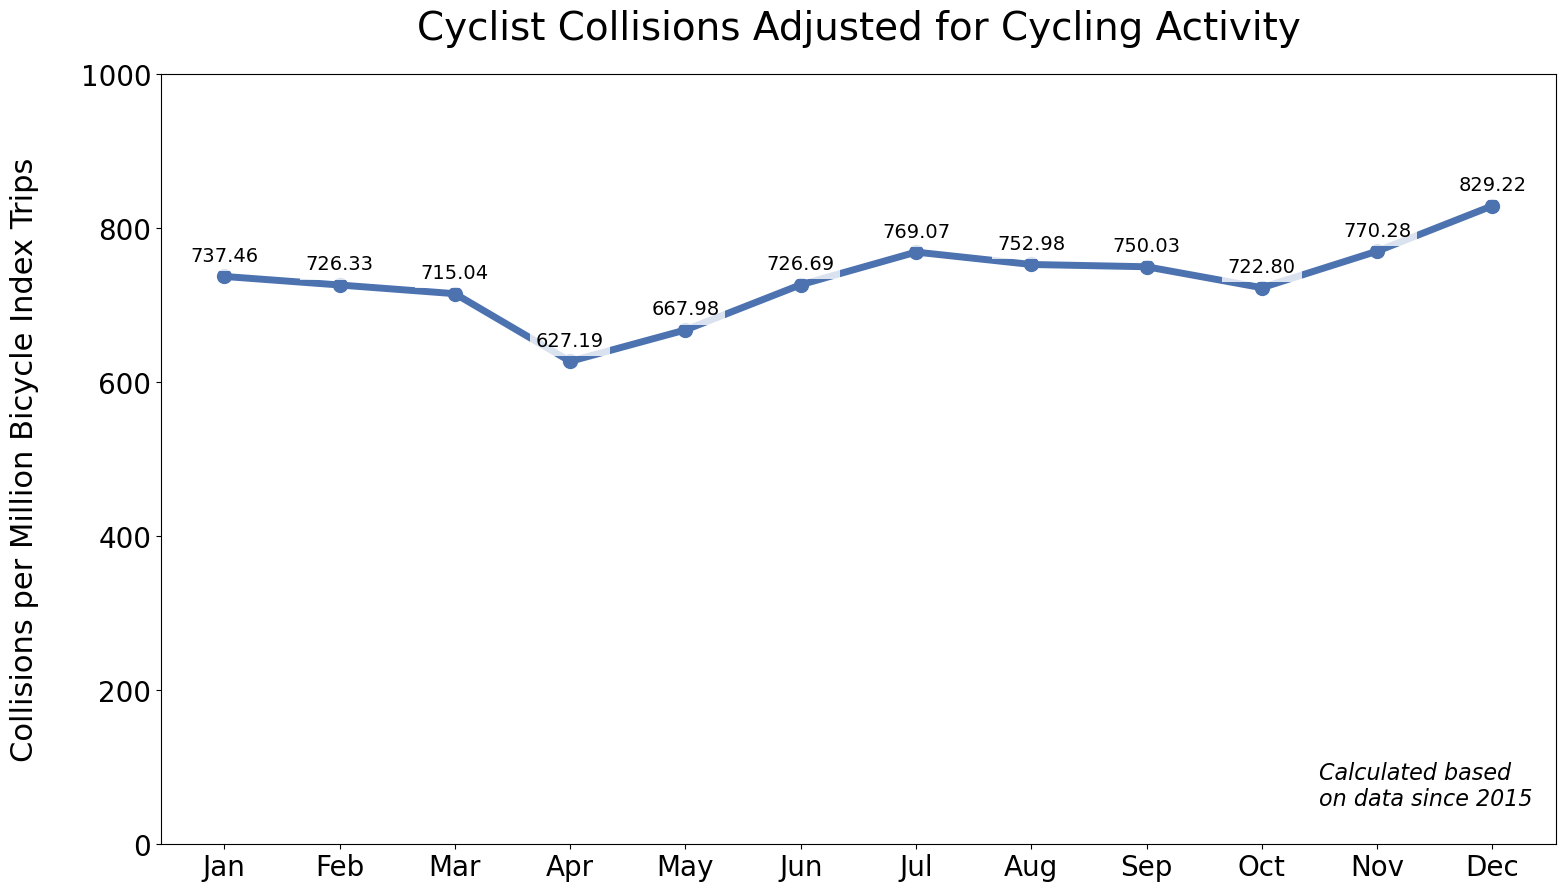

In [24]:
month_groupby = collision_groupby(serious15, serious15.index.month)
bike_groupby = (
    bike_index.groupby(by=bike_index.index.month)["NYC Bicycle Counts"].sum() / MILLION
)
normalized = month_groupby.divide(bike_groupby, axis=0)
normalized.index = normalized.index.map(MONTHS_MAP)
data_to_plot = [(normalized.index.values, normalized["Cyclist Collisions"])]
groups = [
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    title="Cyclist Collisions Adjusted for Cycling Activity",
    ylabel="Collisions per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1000),
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    text=[0.83, 0.05, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "month_norm_bike.png"),
)

## Weekly Variation

All categories of collisions are most common on Fridays and least common on Sundays

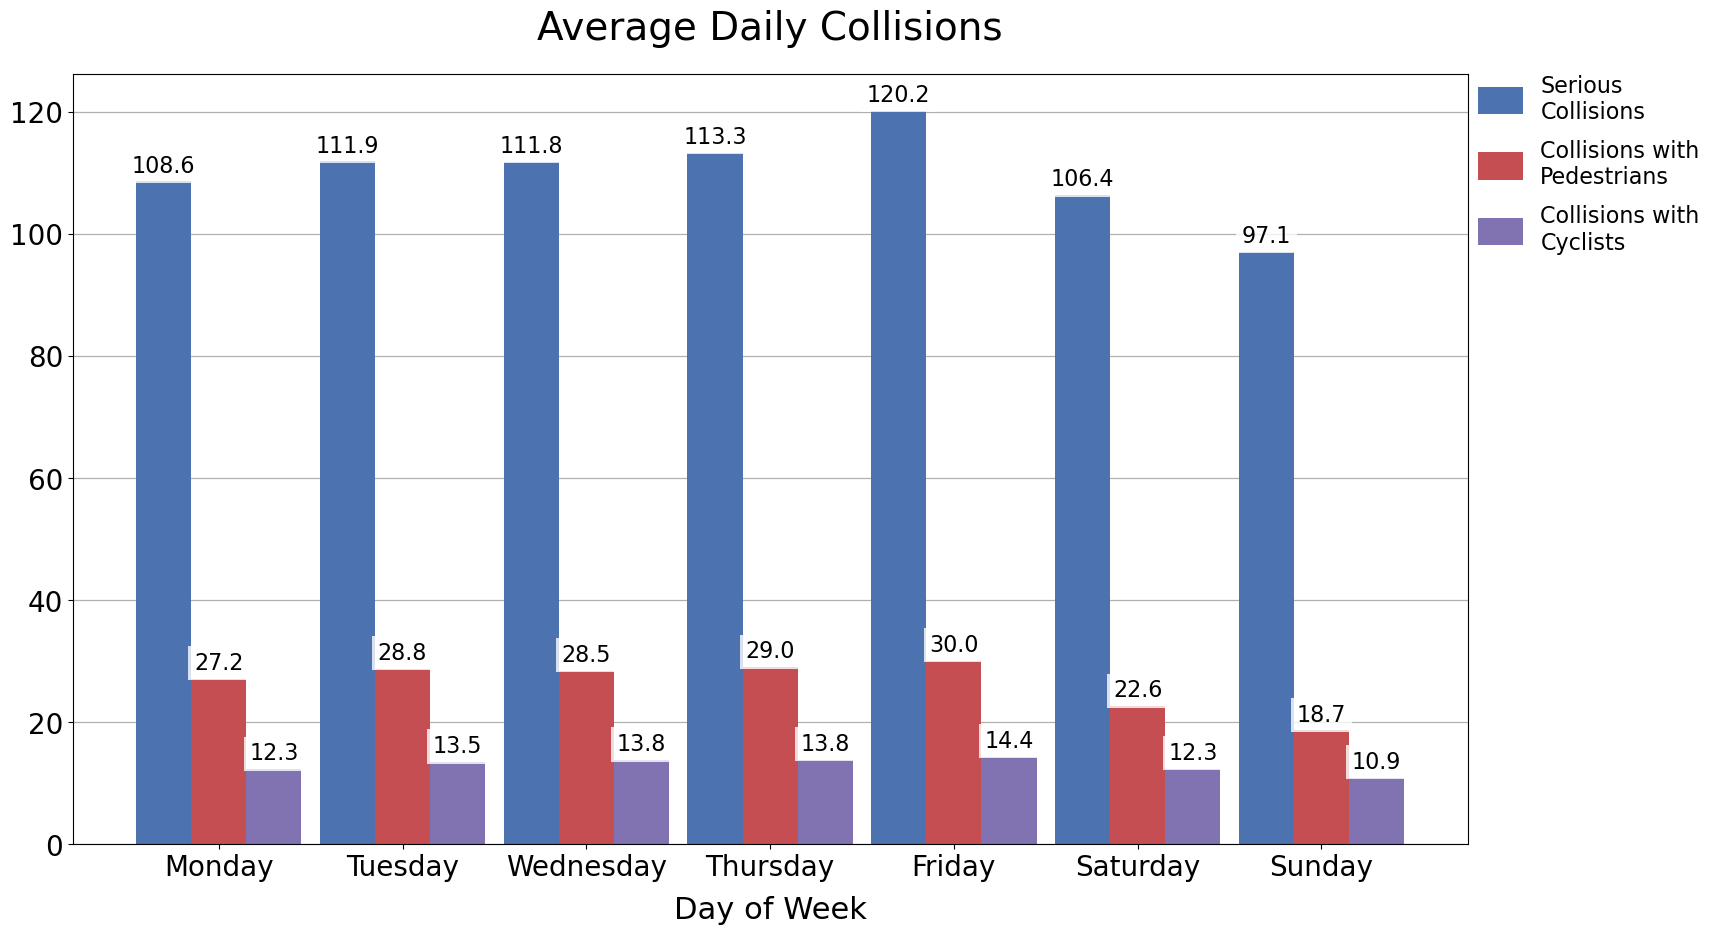

In [25]:
week_groupby = collision_groupby(serious, serious.index.dayofweek)
week_groupby.index = week_groupby.index.map(DAY_OF_WEEK_MAP)
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.grouped_bar_chart(
    week_groupby / total_weeks,
    title="Average Daily Collisions",
    xlabel="Day of Week",
    bar_digits=1,
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.04, 0.9)},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "monthly.png"),
)

## Normalized Weekly Variation
- Collisions per day of the week are fairly consistent when adjusted for activity levels.

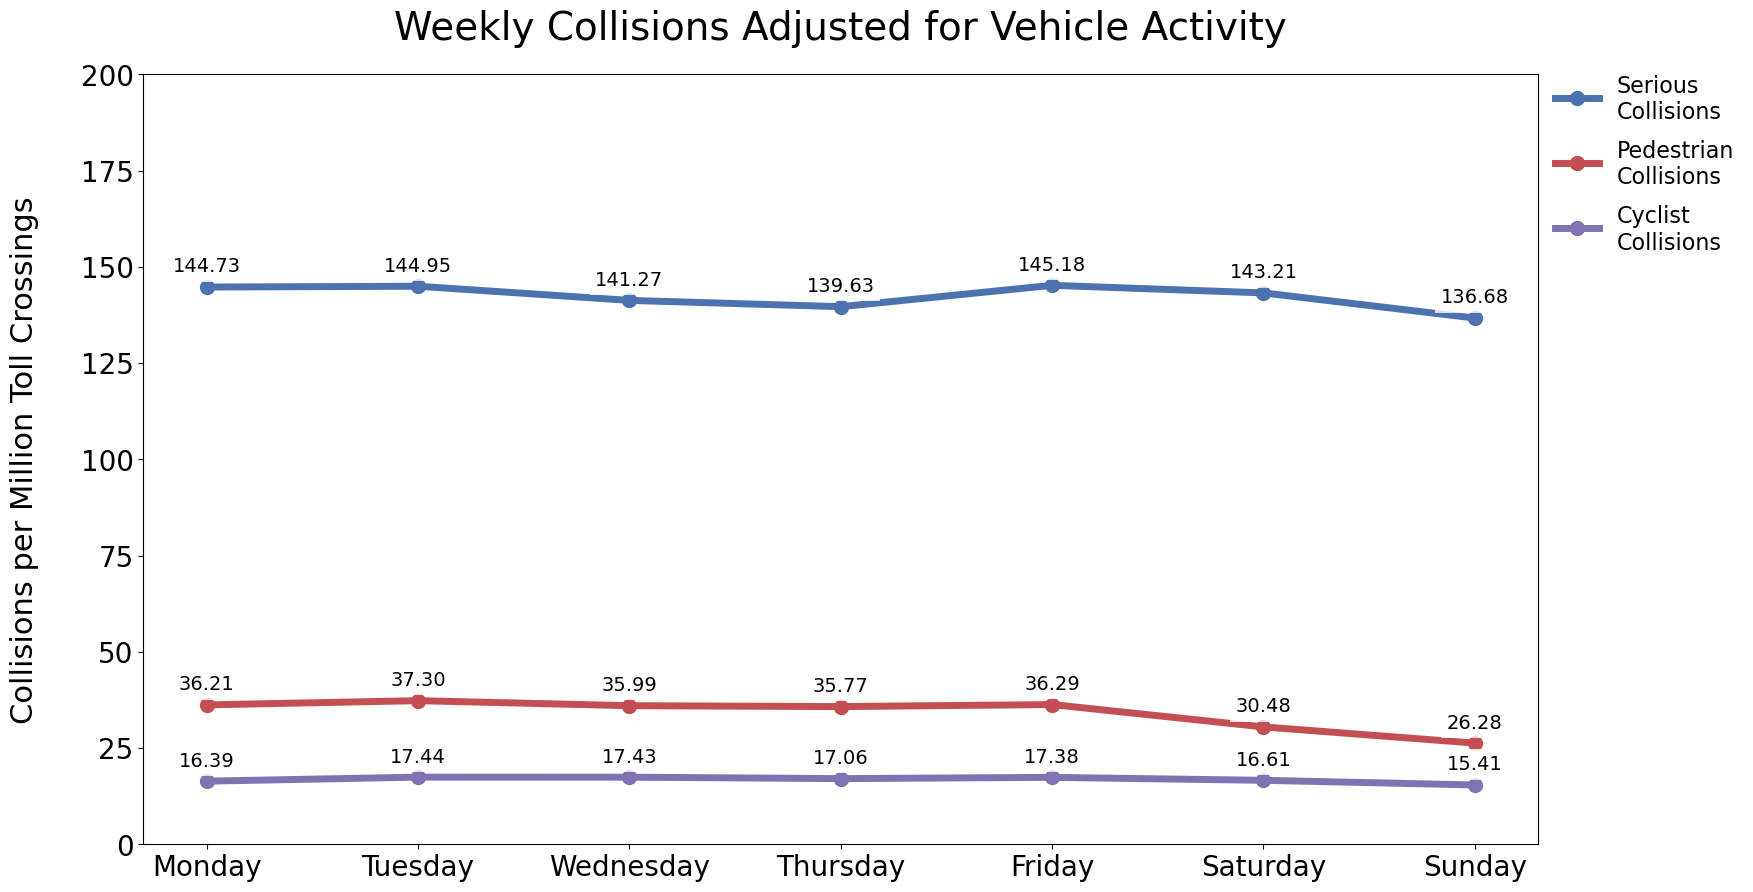

In [26]:
mta_groupby = (
    mta_crossings.groupby(by=mta_crossings.index.dayofweek)["Sum Vehicles"].sum()
    / MILLION
)
mta_groupby.index = mta_groupby.index.map(DAY_OF_WEEK_MAP)
normalized = week_groupby.divide(mta_groupby, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["Serious Collisions"]),
    (normalized.index.values, normalized["Pedestrian Collisions"]),
    (normalized.index.values, normalized["Cyclist Collisions"]),
]
groups = [
    "Serious Collisions",
    "Pedestrian Collisions",
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    title="Weekly Collisions Adjusted for Vehicle Activity",
    ylabel="Collisions per Million Toll Crossings",
    ylabel_rotation="vertical",
    ylim=(0, 200),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.02, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "week_norm_vehicle.png"),
)

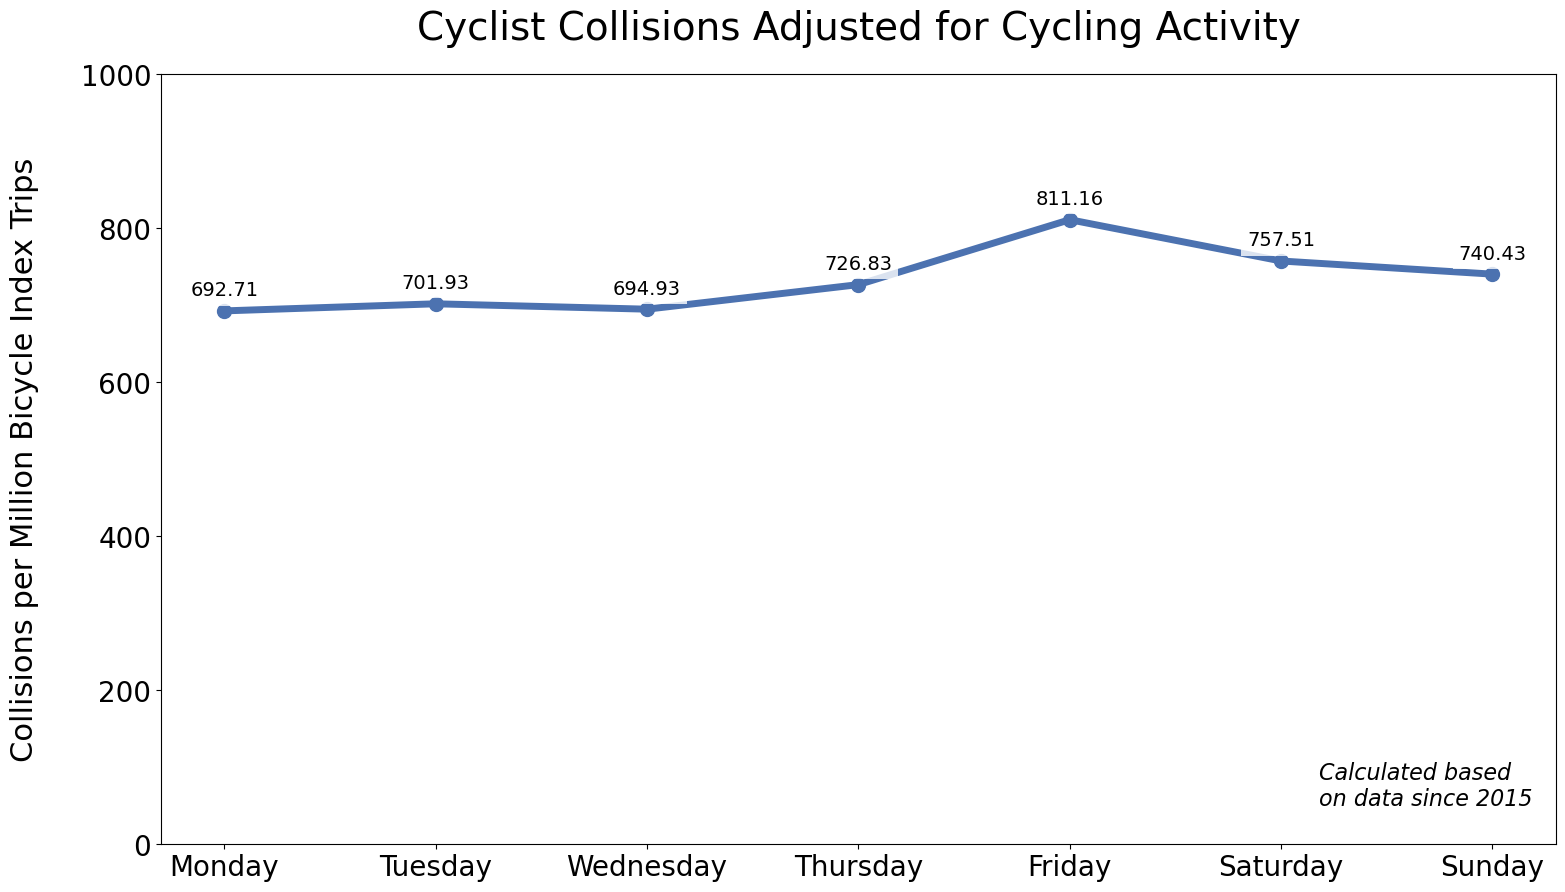

In [27]:
week_groupby = collision_groupby(serious15, serious15.index.dayofweek)
bike_groupby = (
    bike_index.groupby(by=bike_index.index.dayofweek)["NYC Bicycle Counts"].sum()
    / MILLION
)
normalized = week_groupby.divide(bike_groupby, axis=0)
normalized.index = normalized.index.map(DAY_OF_WEEK_MAP)
data_to_plot = [(normalized.index.values, normalized["Cyclist Collisions"])]
groups = ["Cyclist Collisions"]
viz.line_chart(
    data_to_plot,
    title="Cyclist Collisions Adjusted for Cycling Activity",
    ylabel="Collisions per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1000),
    majortick_locator_x=mpl.ticker.MultipleLocator(1),
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 2,
    },
    text=[0.83, 0.05, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "week_norm_bike.png"),
)

## Daily Variation

All categories of collisions are most common in the late afternoon / early evening, ~2-7pm (hours 14-19).

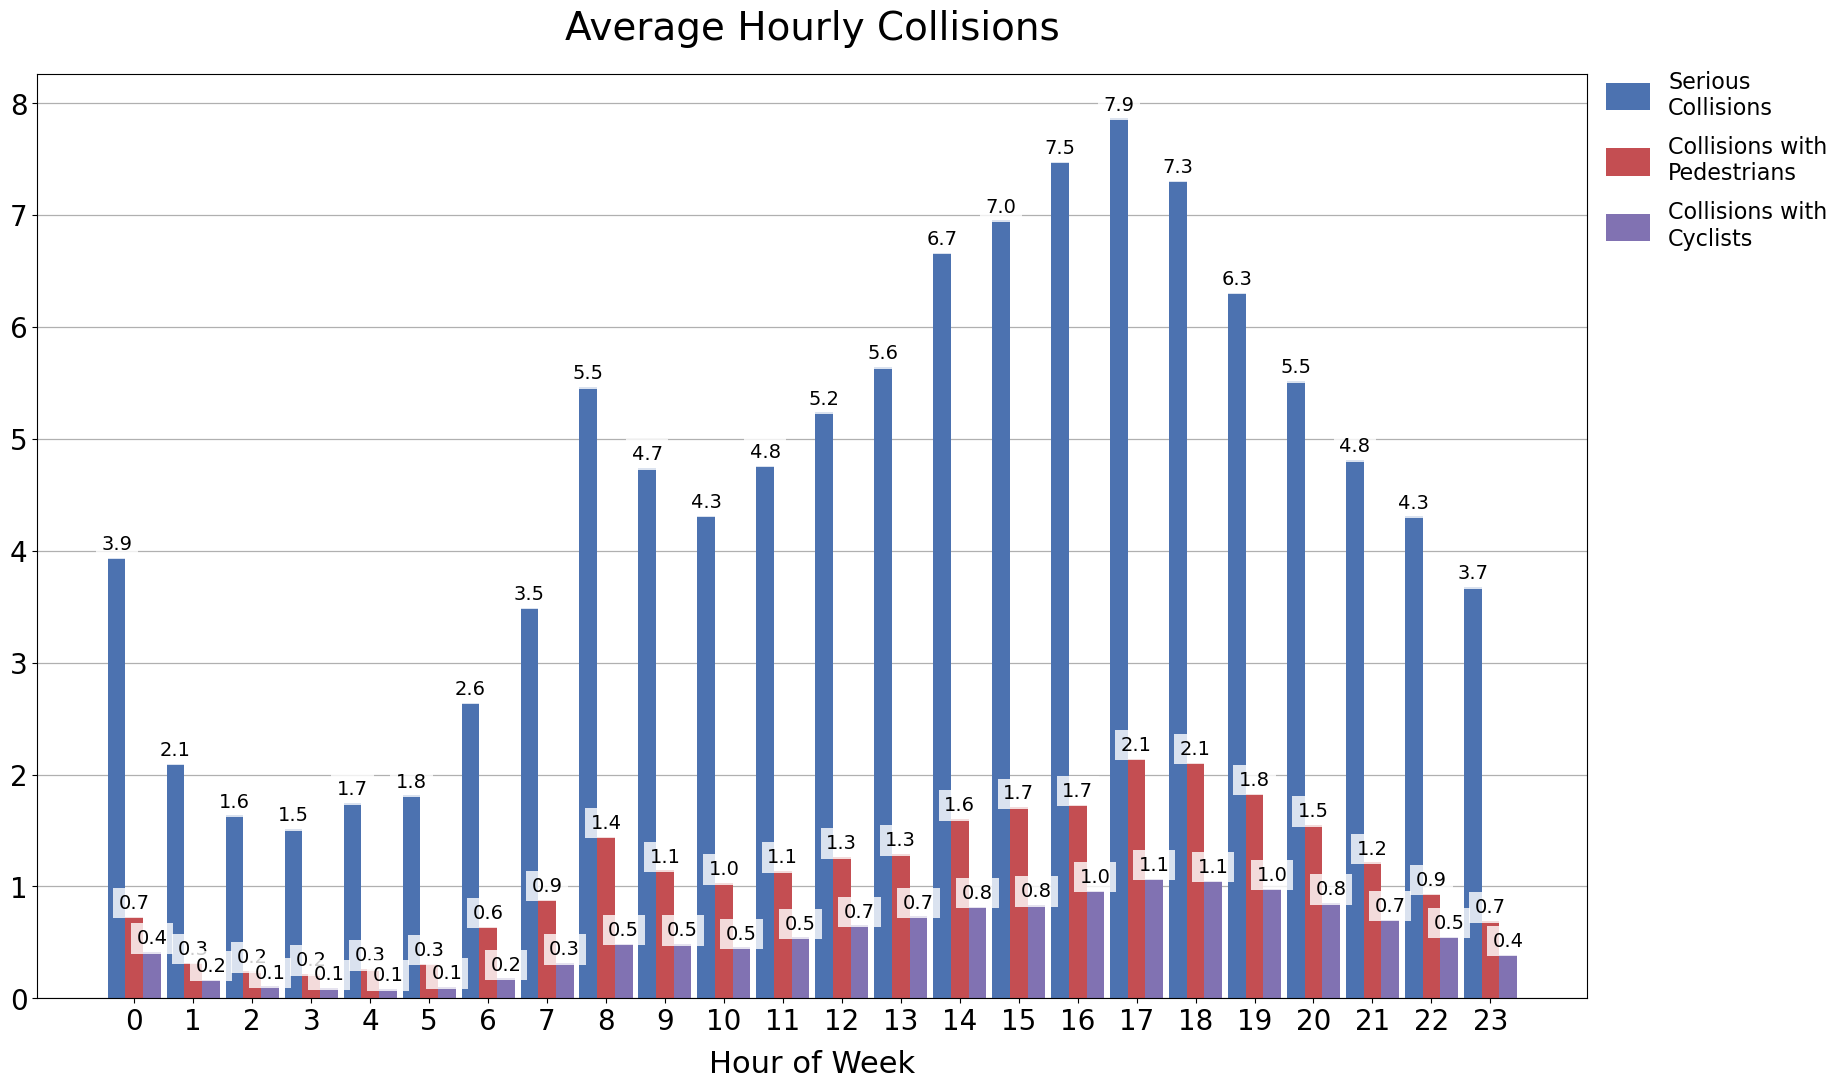

In [28]:
hour_groupby = collision_groupby(serious, serious.index.hour)
groups = [
    "Serious Collisions",
    "Collisions with Pedestrians",
    "Collisions with Cyclists",
]
viz.grouped_bar_chart(
    hour_groupby / total_days,
    title="Average Hourly Collisions",
    xlabel="Hour of Week",
    figsize=(20, 12),
    bar_fontsize=14,
    bar_digits=1,
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.03, 0.9)},
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "trends", "monthly.png"),
)

## Normalized Daily Variation

- Normalized serious collisions are dramatically higher from midnight to 4am

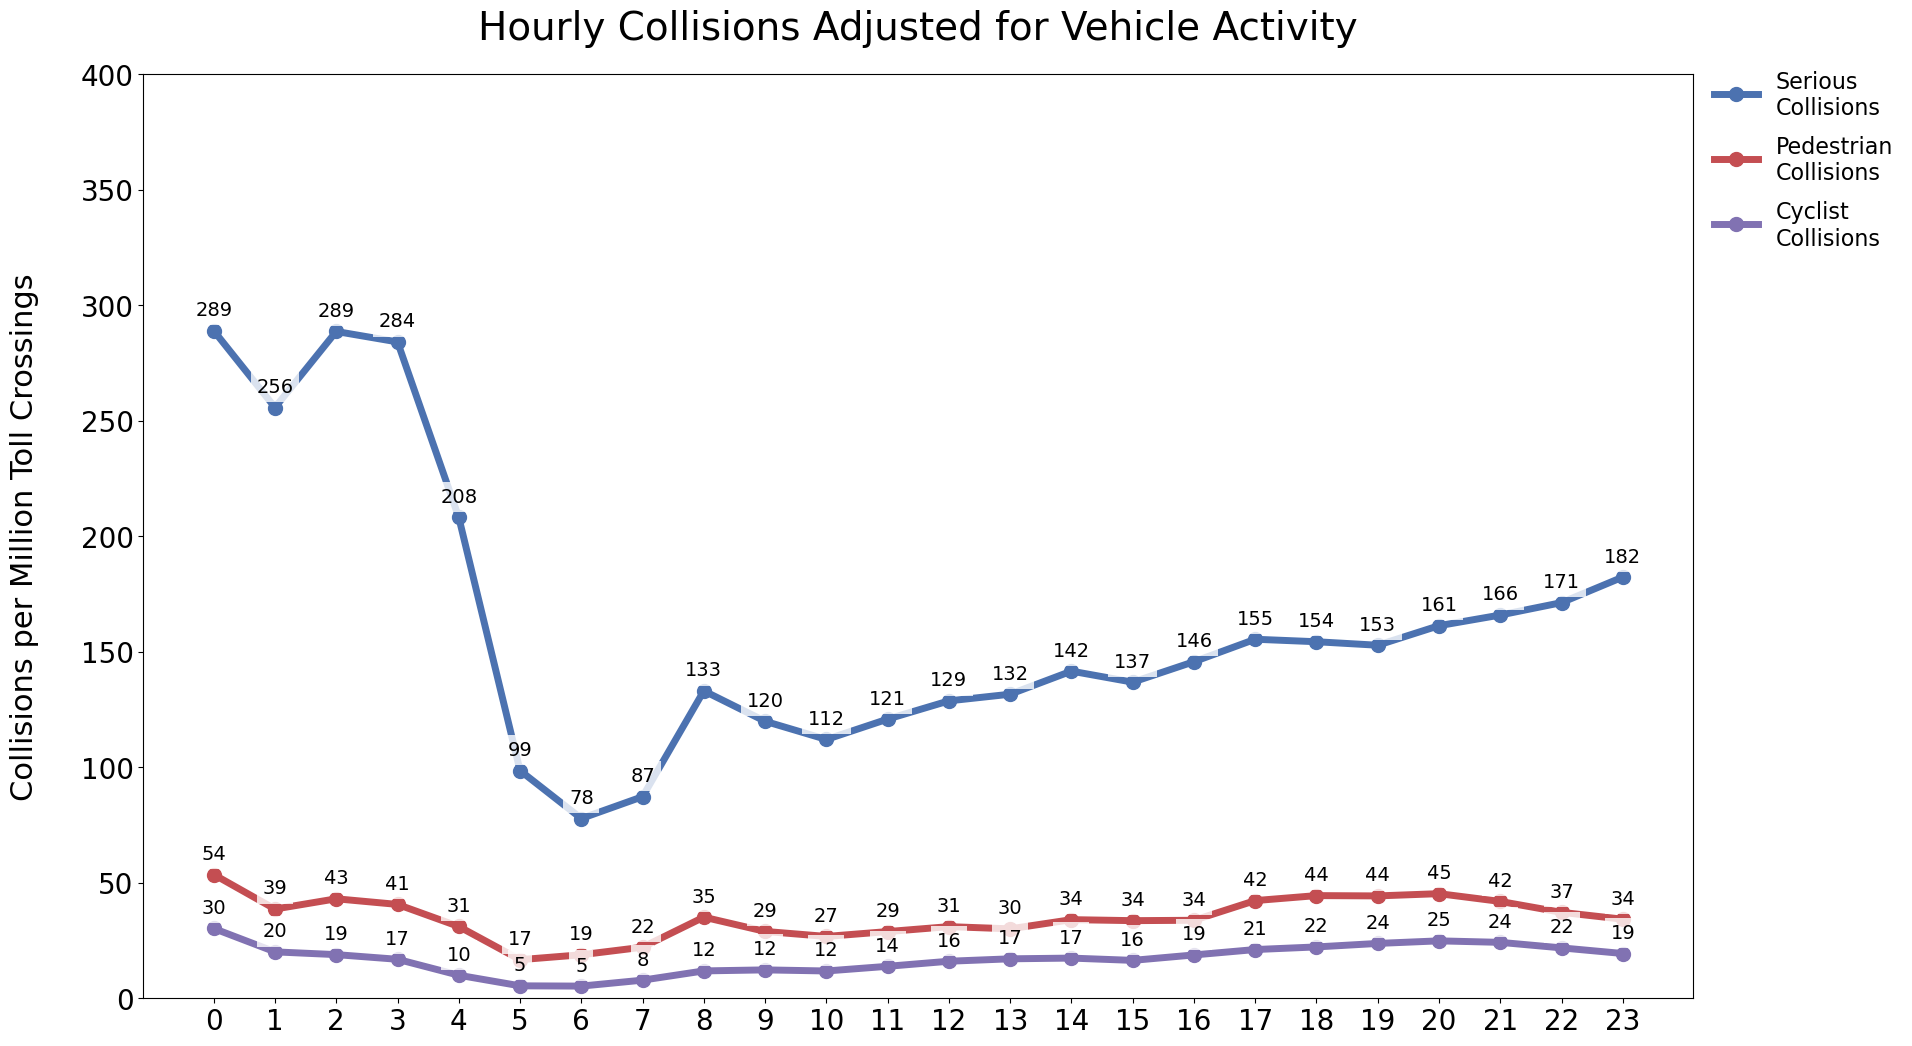

In [29]:
mta_groupby = (
    mta_crossings.groupby(by=mta_crossings.index.hour)["Sum Vehicles"].sum() / MILLION
)
normalized = hour_groupby.divide(mta_groupby, axis=0)
data_to_plot = [
    (normalized.index.values, normalized["Serious Collisions"]),
    (normalized.index.values, normalized["Pedestrian Collisions"]),
    (normalized.index.values, normalized["Cyclist Collisions"]),
]
groups = [
    "Serious Collisions",
    "Pedestrian Collisions",
    "Cyclist Collisions",
]
viz.line_chart(
    data_to_plot,
    figsize=(20, 12),
    title="Hourly Collisions Adjusted for Vehicle Activity",
    ylabel="Collisions per Million Toll Crossings",
    ylabel_rotation="vertical",
    ylim=(0, 400),
    xticks={"ticks": normalized.index.values},
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 0,
    },
    legend_labels=src.strings.add_line_breaks(groups),
    legend_args={"legend_bbox": (1.01, 0.9)},
    save=os.path.join(IMG_DIR, "trends", "hourly_norm_vehicle.png"),
)

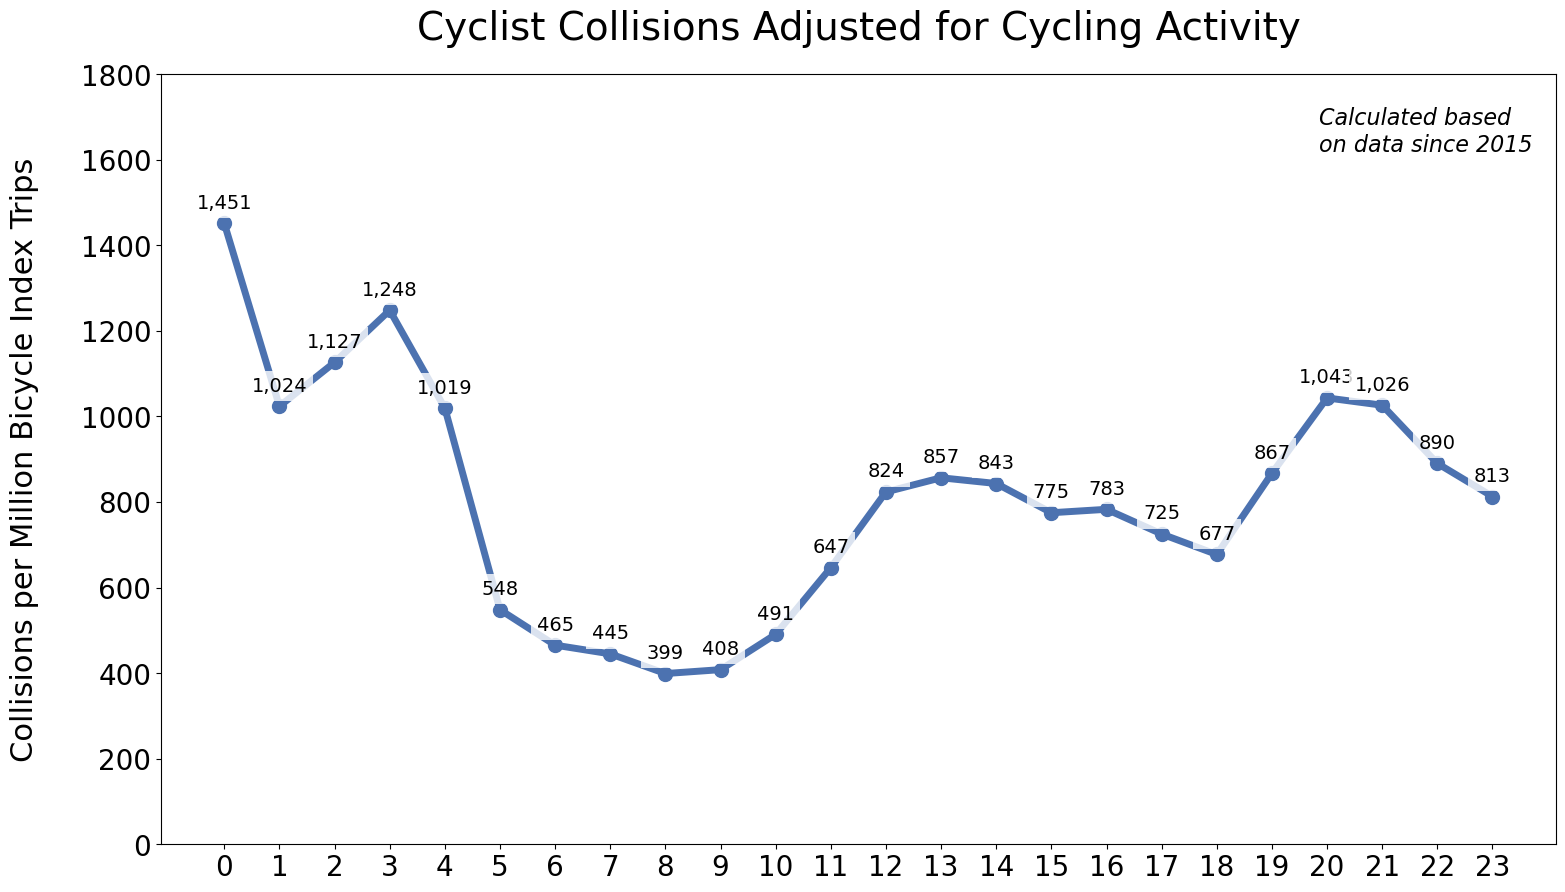

In [30]:
hour_groupby = collision_groupby(serious15, serious15.index.hour)
bike_groupby = (
    bike_index.groupby(by=bike_index.index.hour)["NYC Bicycle Counts"].sum() / MILLION
)
normalized = hour_groupby.divide(bike_groupby, axis=0)
data_to_plot = [(normalized.index.values, normalized["Cyclist Collisions"])]
groups = ["Cyclist Collisions"]
viz.line_chart(
    data_to_plot,
    title="Cyclist Collisions Adjusted for Cycling Activity",
    ylabel="Collisions per Million Bicycle Index Trips",
    ylabel_rotation="vertical",
    ylim=(0, 1800),
    xticks={"ticks": normalized.index.values},
    annotate=True,
    annotate_args={
        "annotate_bbox": {"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
        "annotate_digits": 0,
    },
    text=[0.83, 0.9, NOTE],
    textfontstyle="italic",
    save=os.path.join(IMG_DIR, "trends", "week_norm_bike.png"),
)

# 2D views of when collisions are most common

## Serious Collisions
- Collisions are most common on weekdays in the afternoon / early evening, from approximately 2pm to 7pm (hours 14-19)
- Friday afternoons / early evenings are particularly bad
- Collisions are also elevated during the weekday morning commute, approximately 8am to 10am (hours 8 - 10)
- Early morning collisions, midnight to 6am (hours 0-6), are slightly elevated on the weekends


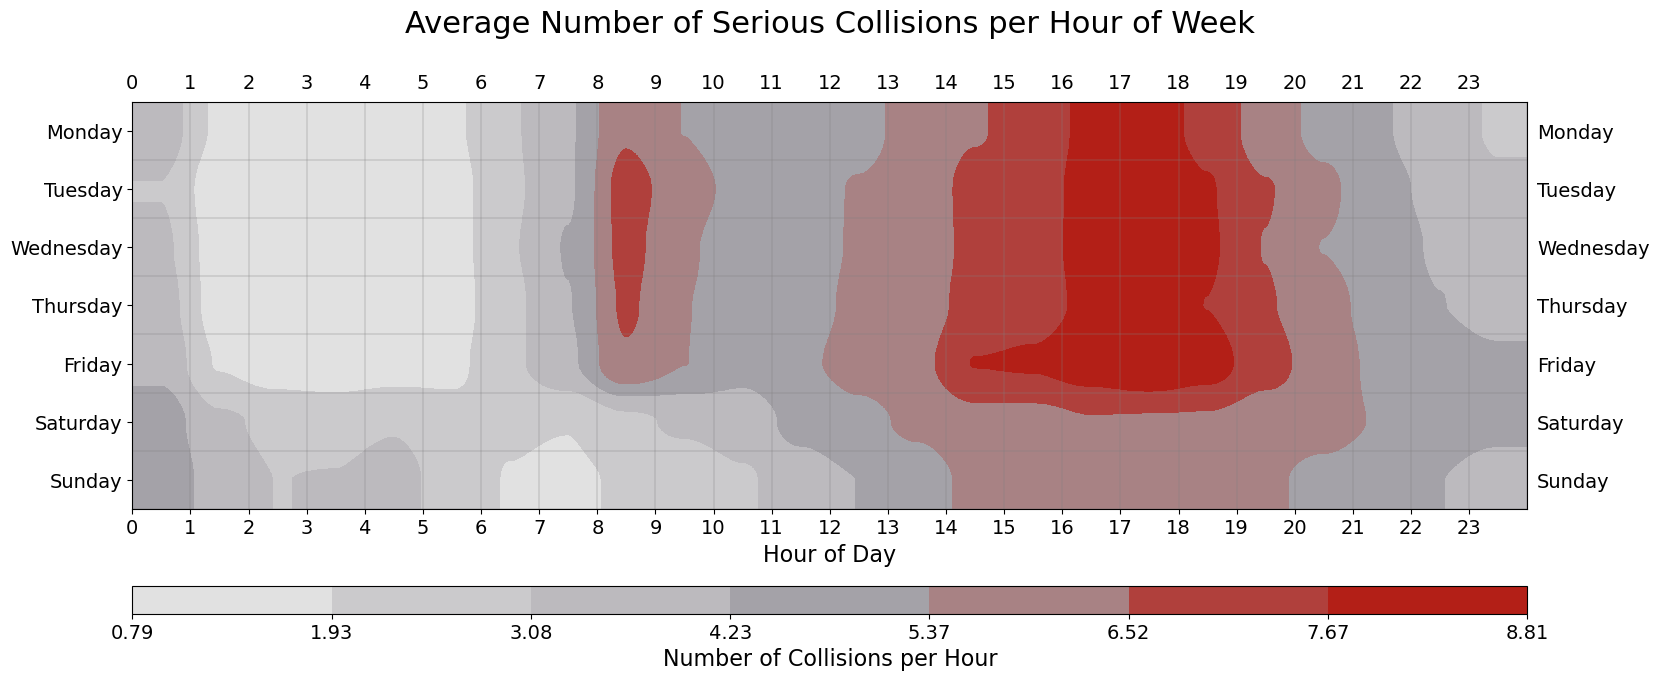

In [31]:
serious_ct = pd.crosstab(
    index=serious.index.dayofweek,
    columns=serious.index.hour,
    values=serious["serious"].values,
    aggfunc="sum",
)
serious_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
serious_labels = src.utils.make_heatmap_labels(
    "Average Number of Serious Collisions per Hour of Week"
)
viz.heat_map(
    serious_ct / total_weeks,
    serious_labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "serious_heat.png"),
)

## Normalized Serious Collisions
- Adjusting for traffic levels, serious collisions are dramatically elevated Saturday and Sunday mornings from 2am to 5am
- In general, collisions are elevated at night relative to vehicle activity
- Intoxicated driving may be a key contributor to serious collisions

Preparing cross-tab summing up vehicle crossing per hour per week that will normalize the 2D views

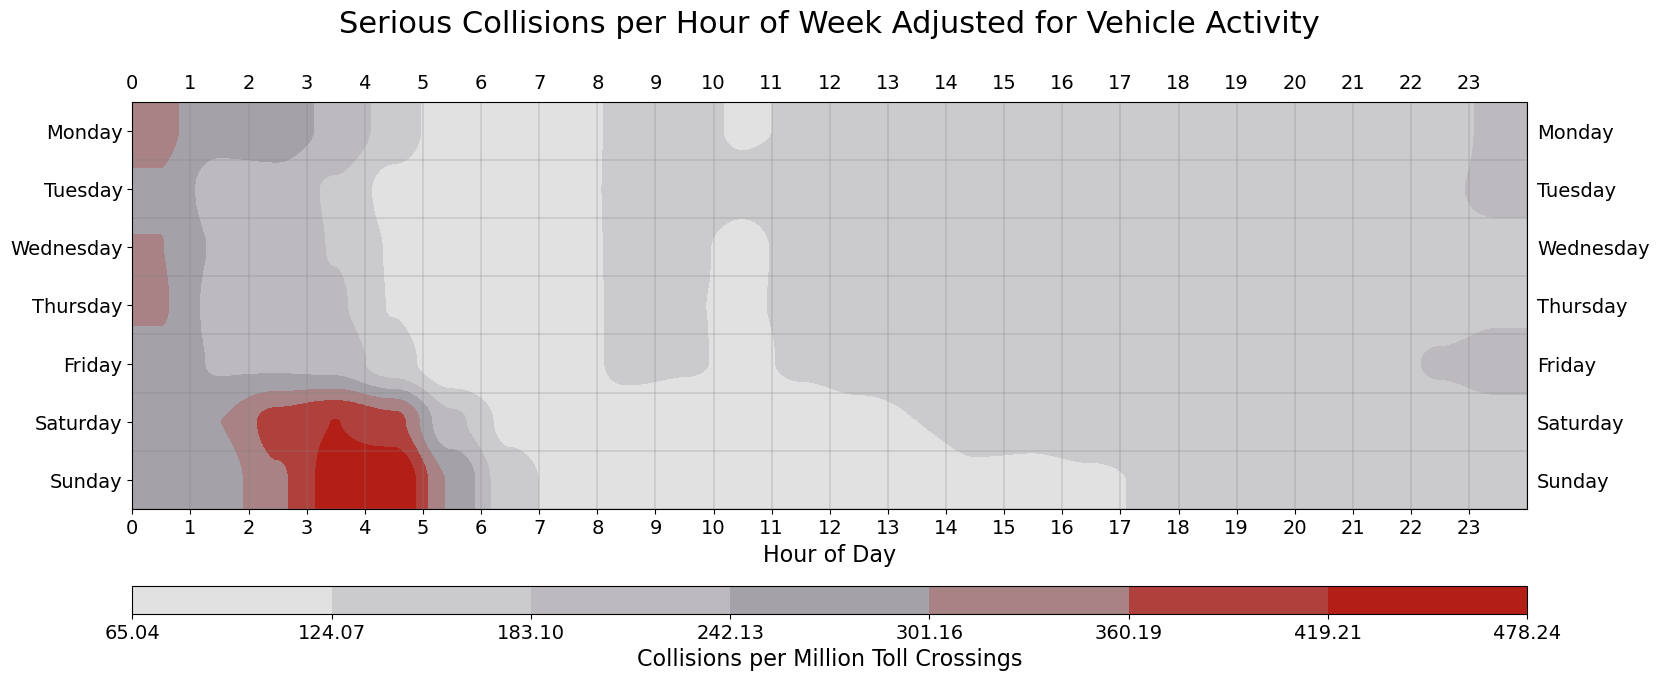

In [32]:
traffic_ct = (
    pd.crosstab(
        index=mta_crossings.index.dayofweek,
        columns=mta_crossings.index.hour,
        values=mta_crossings["Sum Vehicles"].values,
        aggfunc="sum",
    )
    / MILLION
)
traffic_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
labels = src.utils.make_heatmap_labels(
    "Serious Collisions per Hour of Week Adjusted for Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.heat_map(
    serious_ct / traffic_ct,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "serious_heat_norm_vehicle.png"),
)

## Fatal Collisions
- The most prominent cluster of fatalities occurs Saturday and Sunday mornings between 3am and 5am. Intoxication is likely a major factor in these fatal collisions. Many bars and clubs close around 4am in NYC. 
- A secondary cluster of fatalities occurs Fridays and Saturdays between 5pm and 7pm (hours 17-19)
- Fatal collisions are generally elevated from 5pm to 1am (hours 17 - 1)

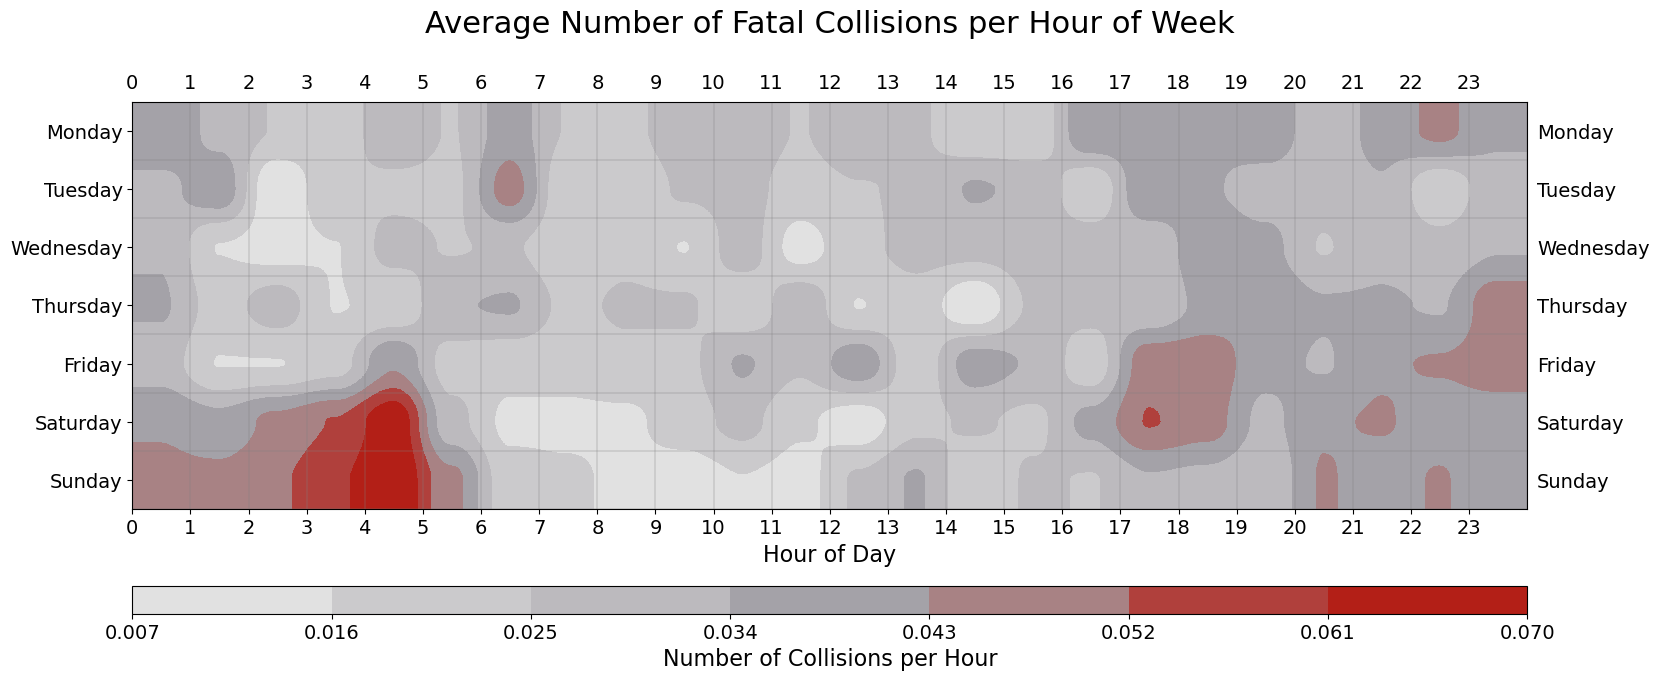

In [33]:
fatal = serious[serious["KILLED"] > 0]
fatal_ct = pd.crosstab(
    index=fatal.index.dayofweek,
    columns=fatal.index.hour,
    values=fatal["KILLED"].values,
    aggfunc="sum",
)
fatal_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
labels = src.utils.make_heatmap_labels(
    "Average Number of Fatal Collisions per Hour of Week"
)
viz.heat_map(
    fatal_ct / total_weeks,
    labels,
    interpolation="hanning",
    cbar_format=lambda tick: f"{tick:.3f}",
    save=os.path.join(IMG_DIR, "trends", "fatal_heat.png"),
)

## Normalized Fatal Collisions
- Fatal collisions are notable higher Saturday and Sunday mornings from 2am to 5am

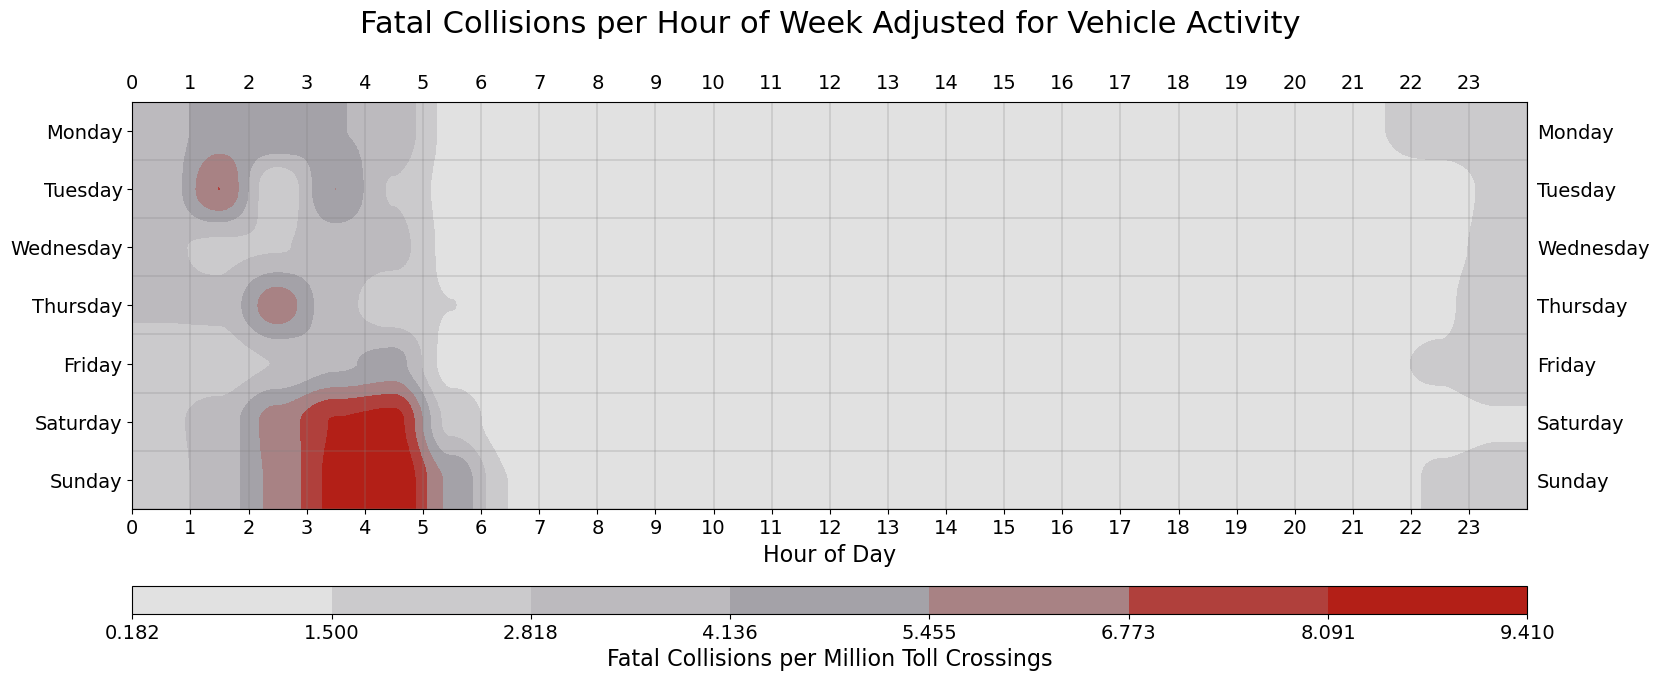

In [34]:
normalized = fatal_ct / traffic_ct
labels = src.utils.make_heatmap_labels(
    "Fatal Collisions per Hour of Week Adjusted for Vehicle Activity",
    cbar_label="Fatal Collisions per Million Toll Crossings",
)
viz.heat_map(
    normalized,
    labels,
    interpolation="hanning",
    cbar_format=lambda tick: f"{tick:.3f}",
    save=os.path.join(IMG_DIR, "trends", "fatal_heat_norm_vehicle.png"),
)

## Collisions with Pedestrians

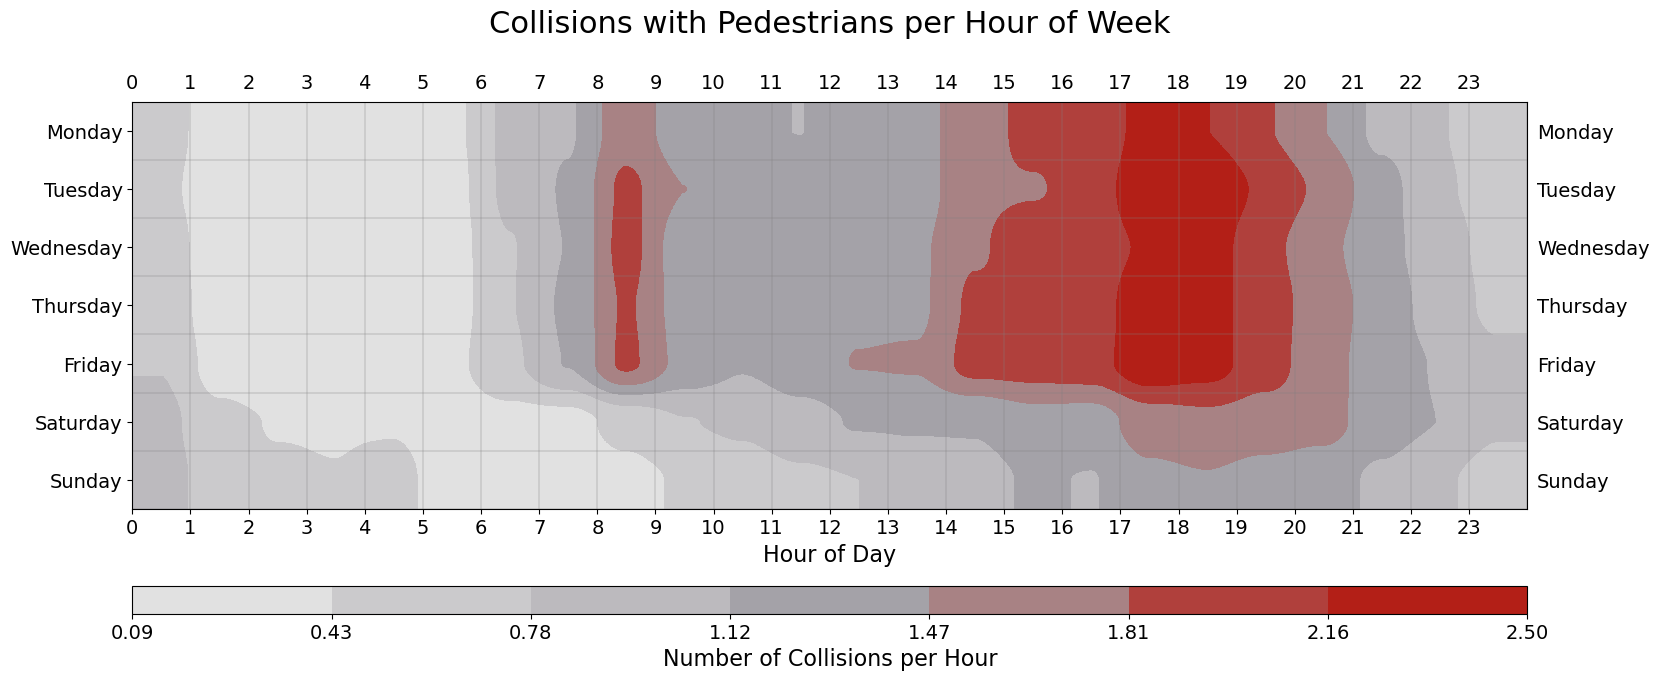

In [35]:
pedestrian_ct = pd.crosstab(
    index=serious.index.dayofweek,
    columns=serious.index.hour,
    values=serious["pedestrian"].values,
    aggfunc="sum",
)
pedestrian_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
labels = src.utils.make_heatmap_labels(
    "Collisions with Pedestrians per Hour of Week",
)
viz.heat_map(
    pedestrian_ct / total_weeks,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "pedestrian_heat.png"),
)

## Normalized Collisions with Pedestrians

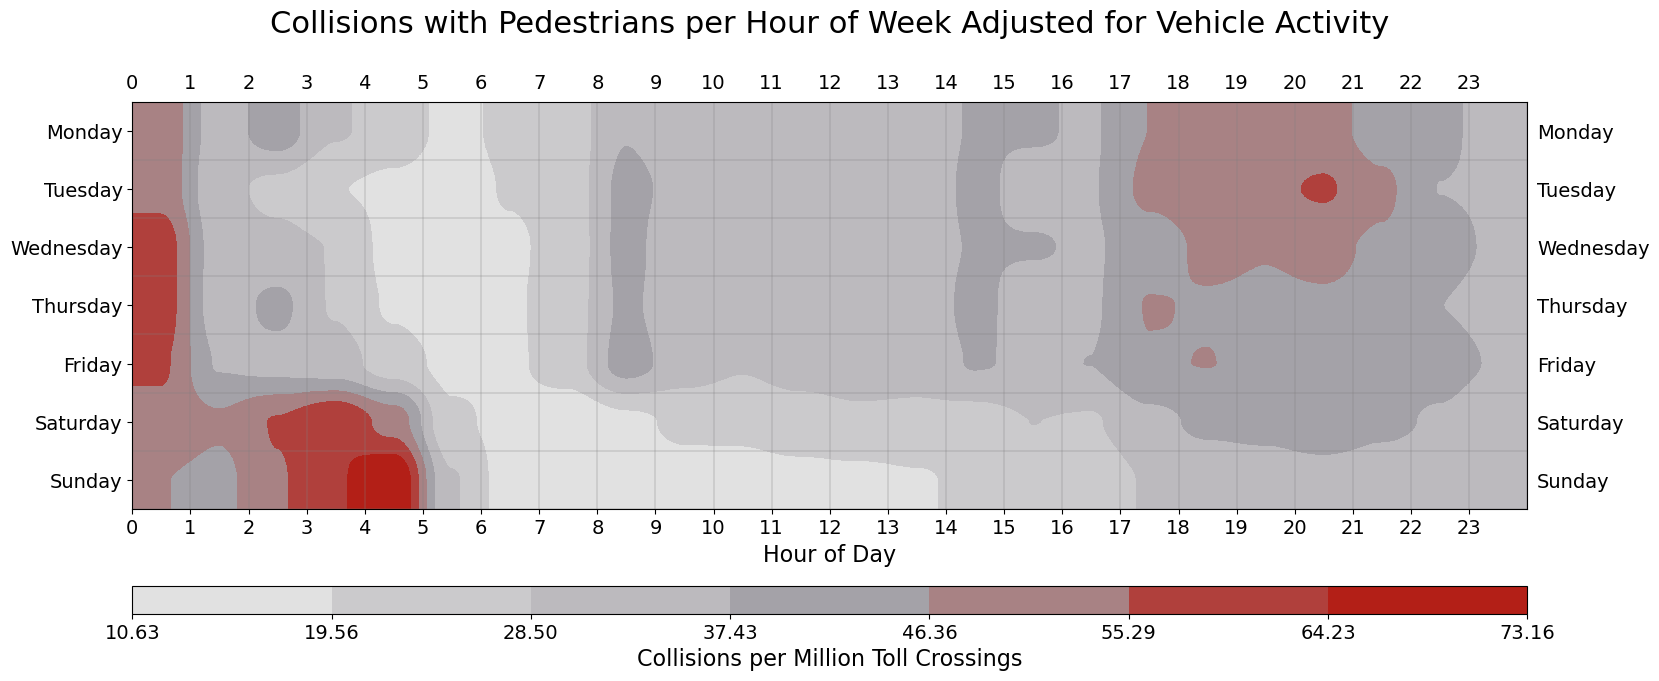

In [36]:
labels = src.utils.make_heatmap_labels(
    "Collisions with Pedestrians per Hour of Week Adjusted for Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.heat_map(
    pedestrian_ct / traffic_ct,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "pedestrian_heat_norm_vehicle.png"),
)

## Collisions with Cyclists

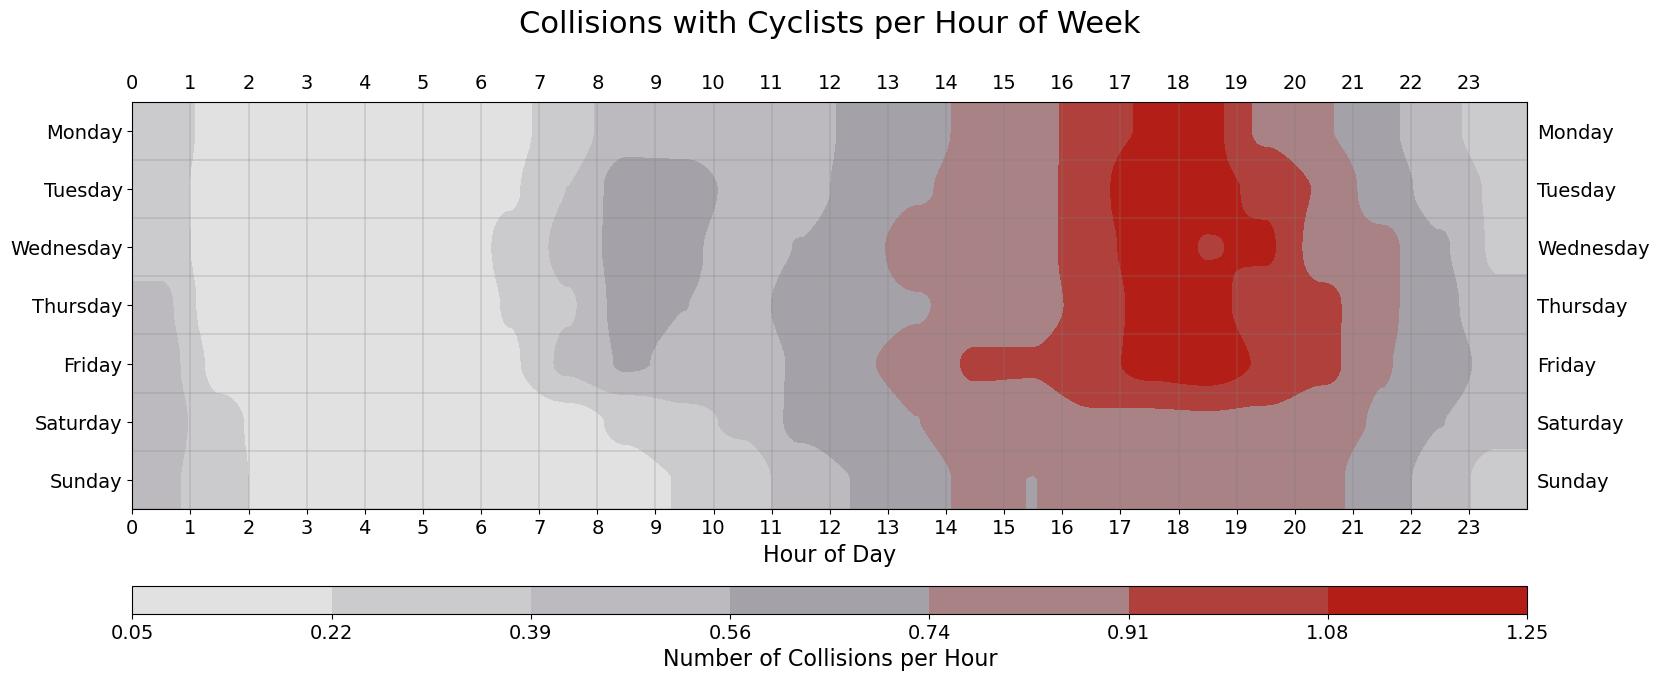

In [37]:
cyclist_ct = pd.crosstab(
    index=serious.index.dayofweek,
    columns=serious.index.hour,
    values=serious["cyclist"].values,
    aggfunc="sum",
)
cyclist_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
labels = src.utils.make_heatmap_labels(
    "Collisions with Cyclists per Hour of Week",
)
viz.heat_map(
    cyclist_ct / total_weeks,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "cyclist_heat.png"),
)

## Normalized Collisions with Cyclists

### Cyclist Collisions Normalized by Vehicle Activity

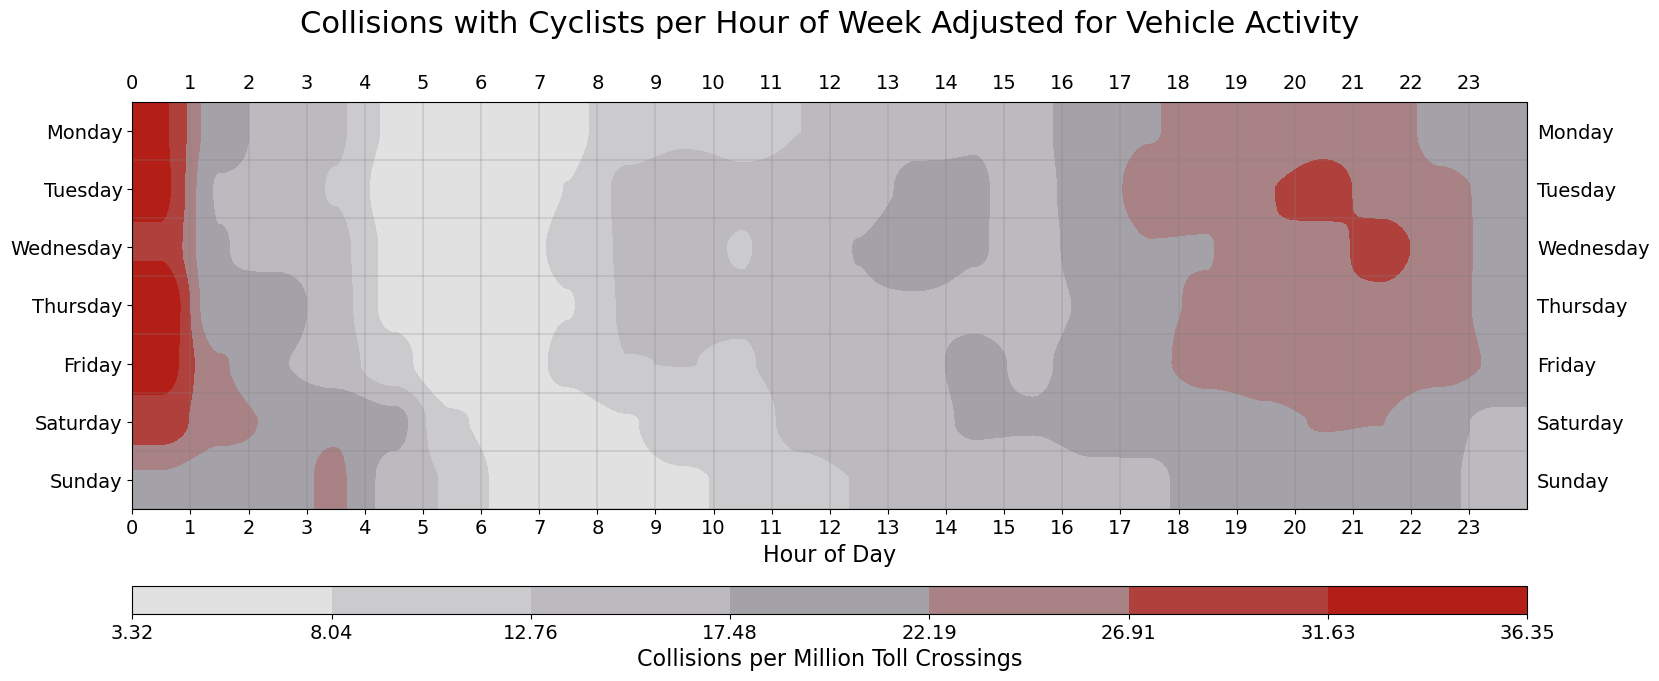

In [38]:
labels = src.utils.make_heatmap_labels(
    "Collisions with Cyclists per Hour of Week Adjusted for Vehicle Activity",
    cbar_label="Collisions per Million Toll Crossings",
)
viz.heat_map(
    cyclist_ct / traffic_ct,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "cyclist_heat_norm_vehicle.png"),
)

### Cyclist Collisions Normalized by an Cycling Activity

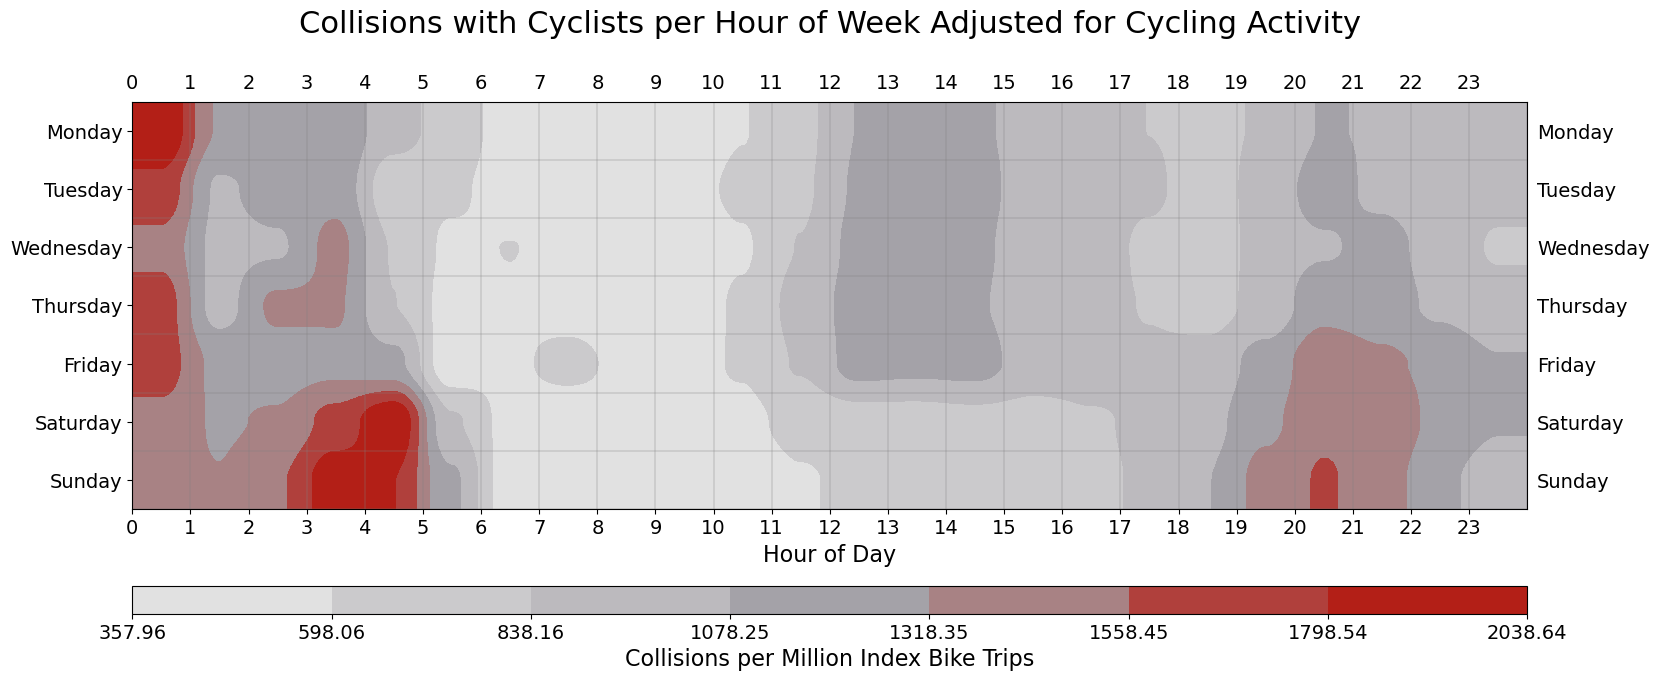

In [39]:
bike_index_ct = (
    pd.crosstab(
        index=bike_index.index.dayofweek,
        columns=bike_index.index.hour,
        values=bike_index["NYC Bicycle Counts"].values,
        aggfunc="sum",
    )
    / MILLION
)
bike_index_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
normalized = cyclist_ct / bike_index_ct
labels = src.utils.make_heatmap_labels(
    "Collisions with Cyclists per Hour of Week Adjusted for Cycling Activity",
    cbar_label="Collisions per Million Index Bike Trips",
)
viz.heat_map(
    normalized,
    labels,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "trends", "serious_heat_norm_cyclist.png"),
)

## Weekly Serious Collisions Through the Seasons

- Serious collisions are less common in the winter
- There is a notable cluster of serious collisions during fall weekday mornings
- Summer appears to have more serious collisions at night, ~8pm - 5am (hours 20-5) than other seasons

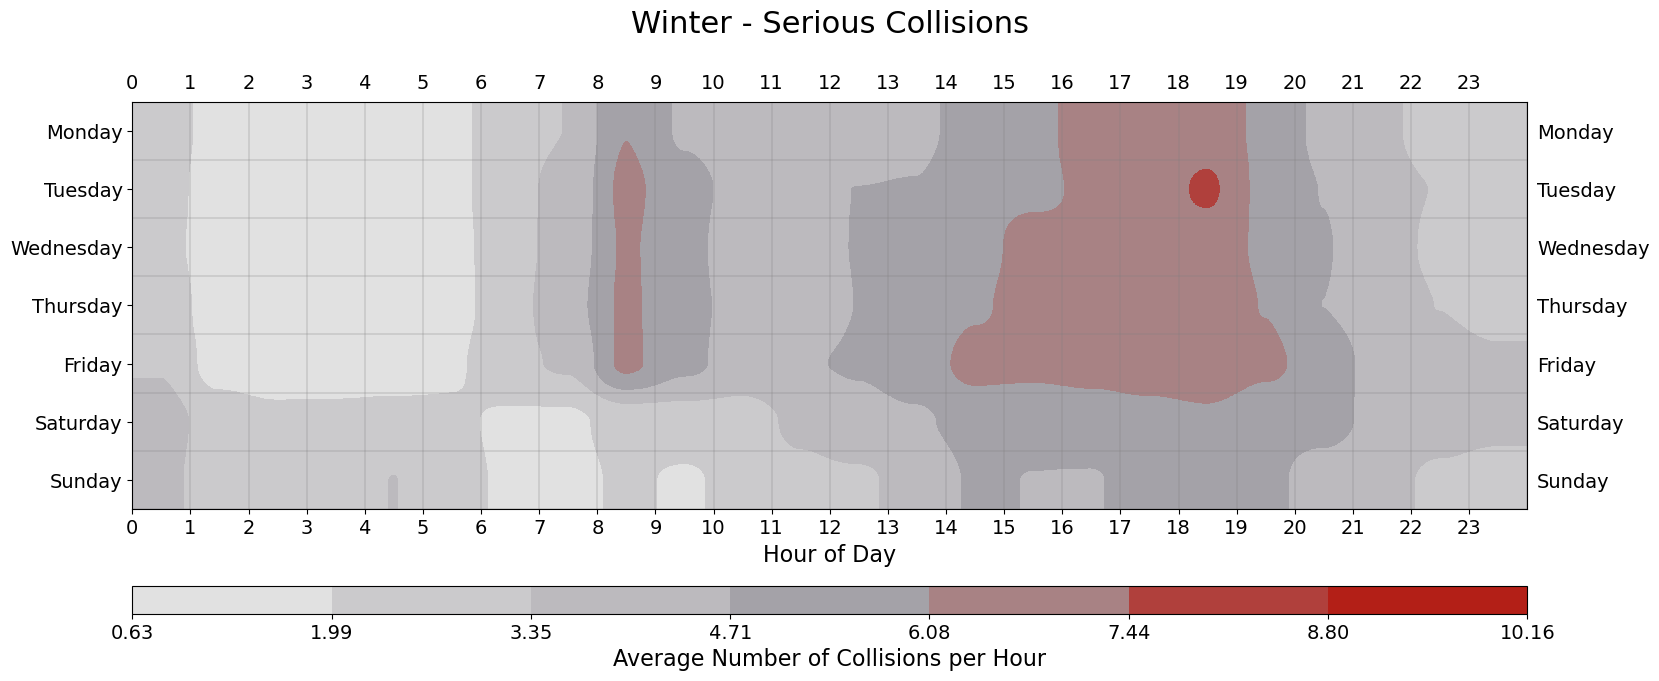

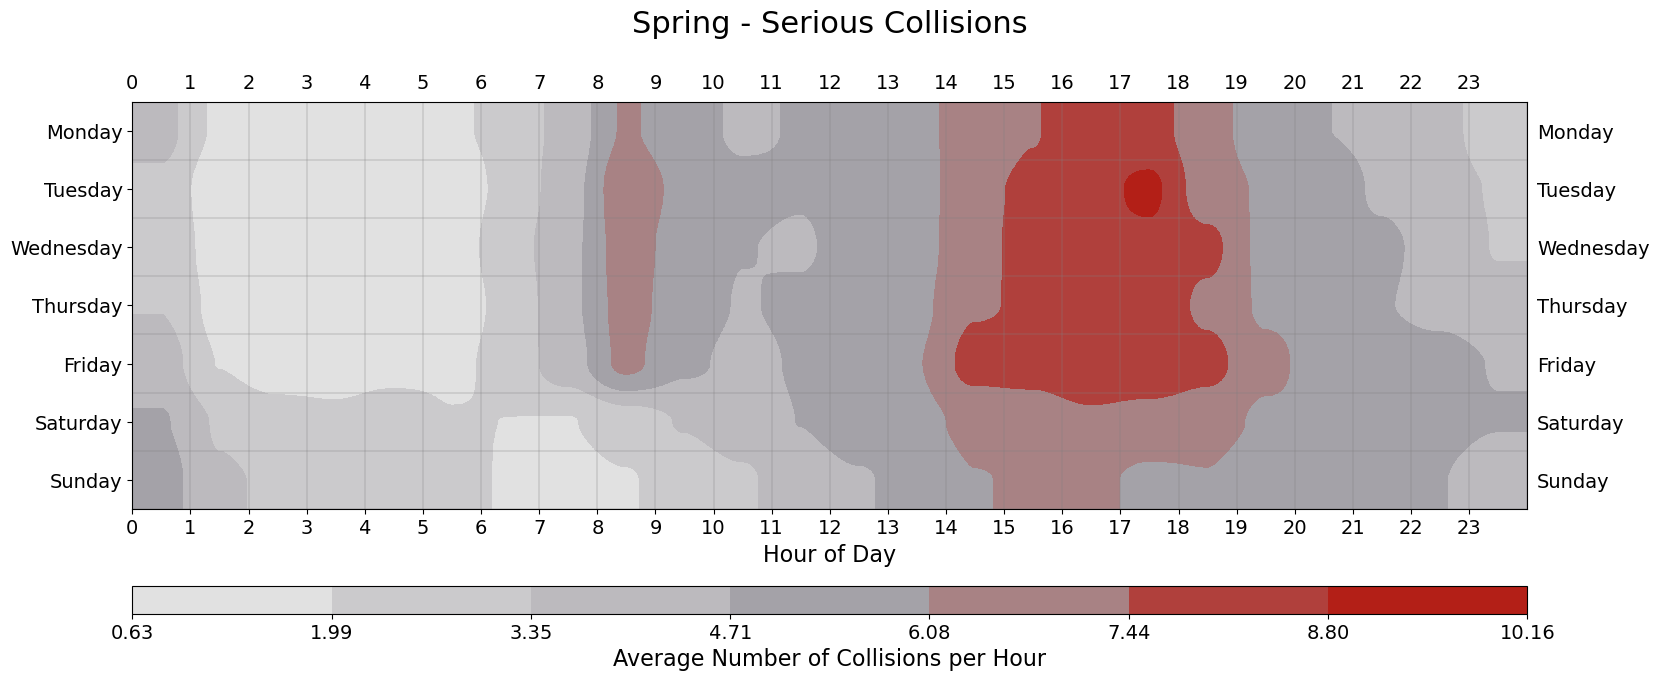

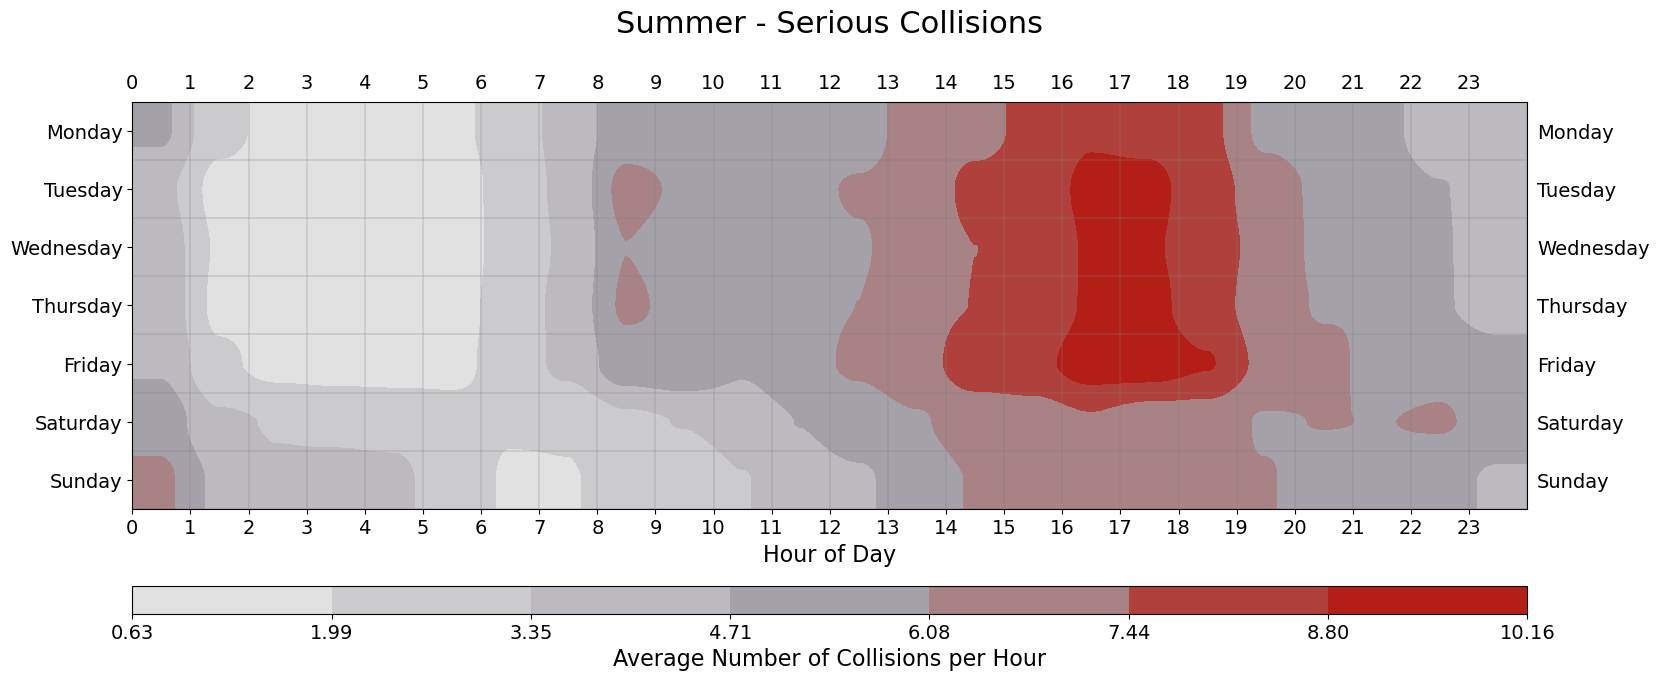

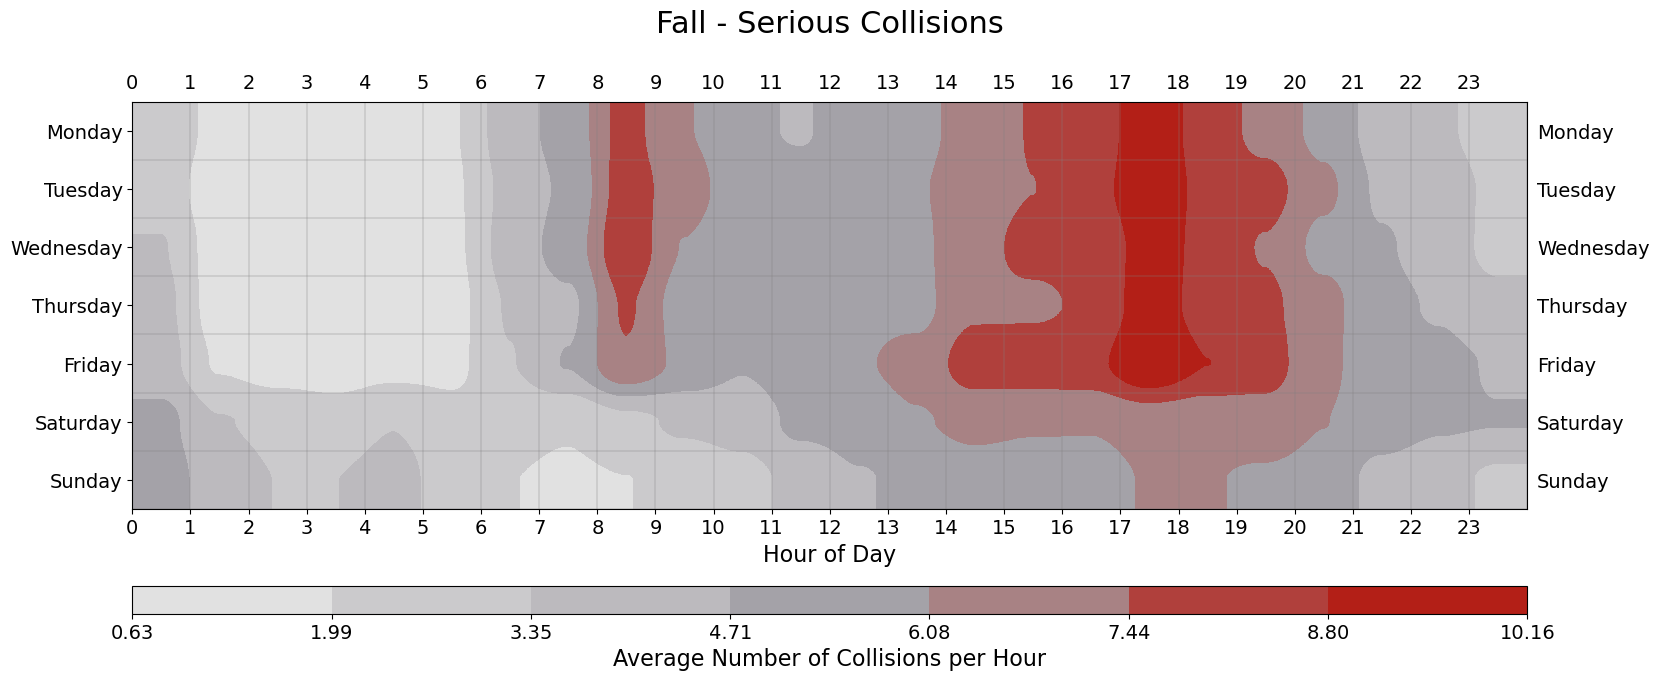

In [40]:
mn_mx_serious = src.utils.min_max_across_crosstabs(
    SEASONS,
    serious["season"],
    serious.index.dayofweek,
    serious.index.hour,
    divisor=(total_weeks / 4),
)
for season in SEASONS:
    season_df = serious[serious["season"] == season]
    season_ct = pd.crosstab(
        index=season_df.index.dayofweek,
        columns=season_df.index.hour,
    )
    season_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Serious Collisions",
        cbar_label="Average Number of Collisions per Hour",
    )
    viz.heat_map(
        season_ct / (total_weeks / 4),
        season_labels,
        interpolation="hanning",
        min_max=mn_mx_serious,
        save=os.path.join(IMG_DIR, f"{season.lower()}_serious_heat.png"),
    )

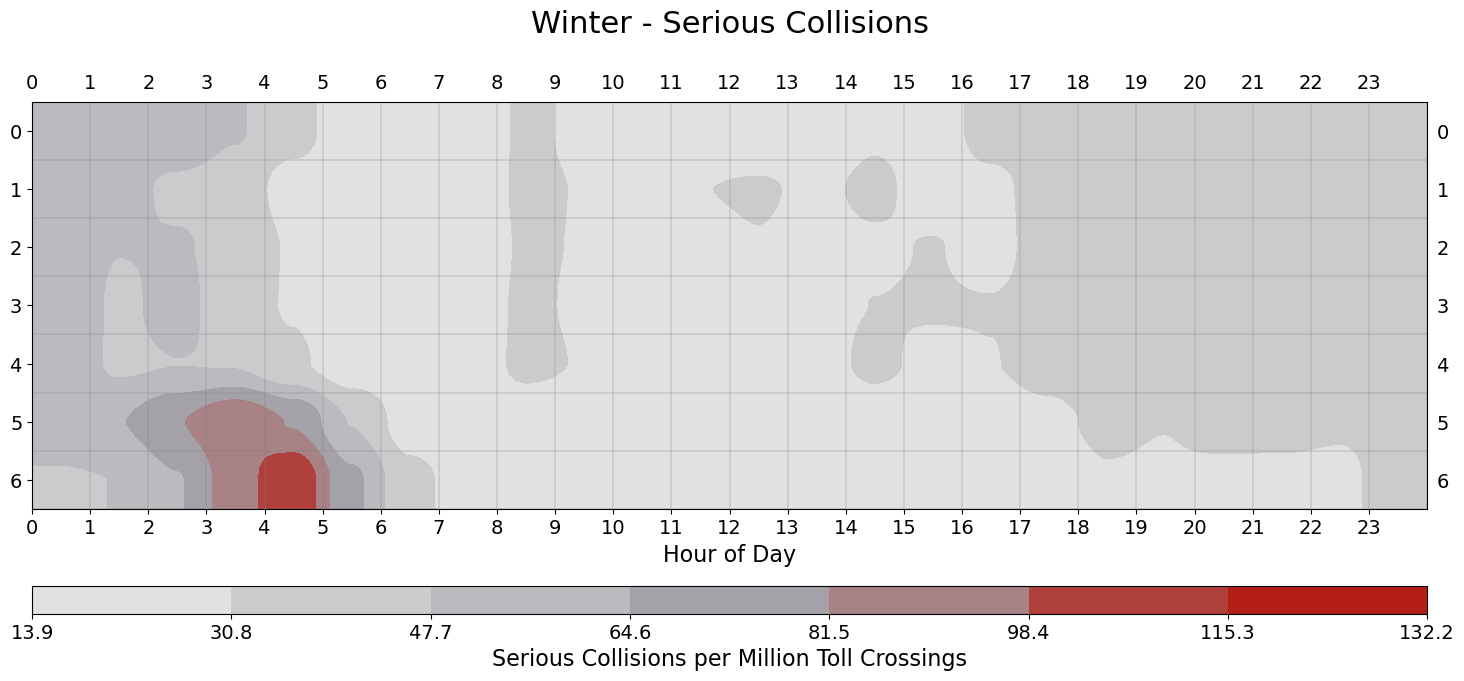

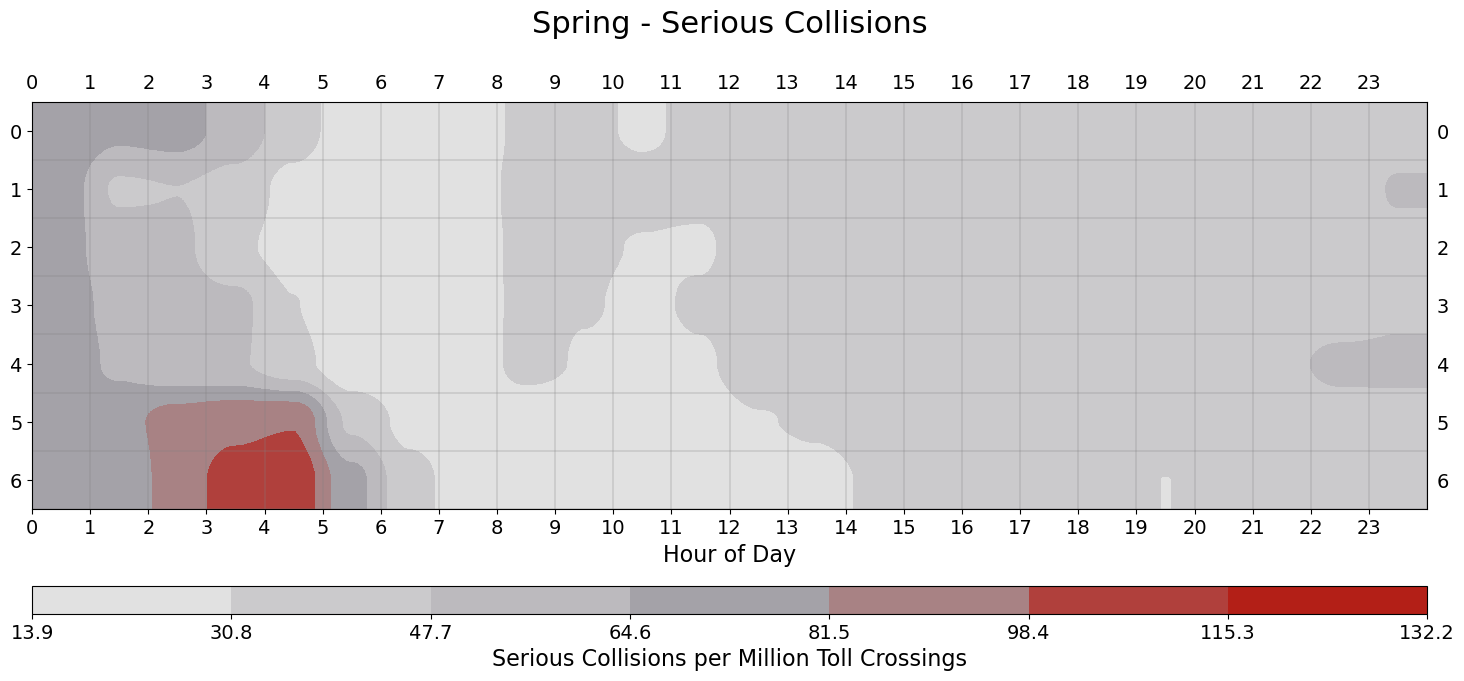

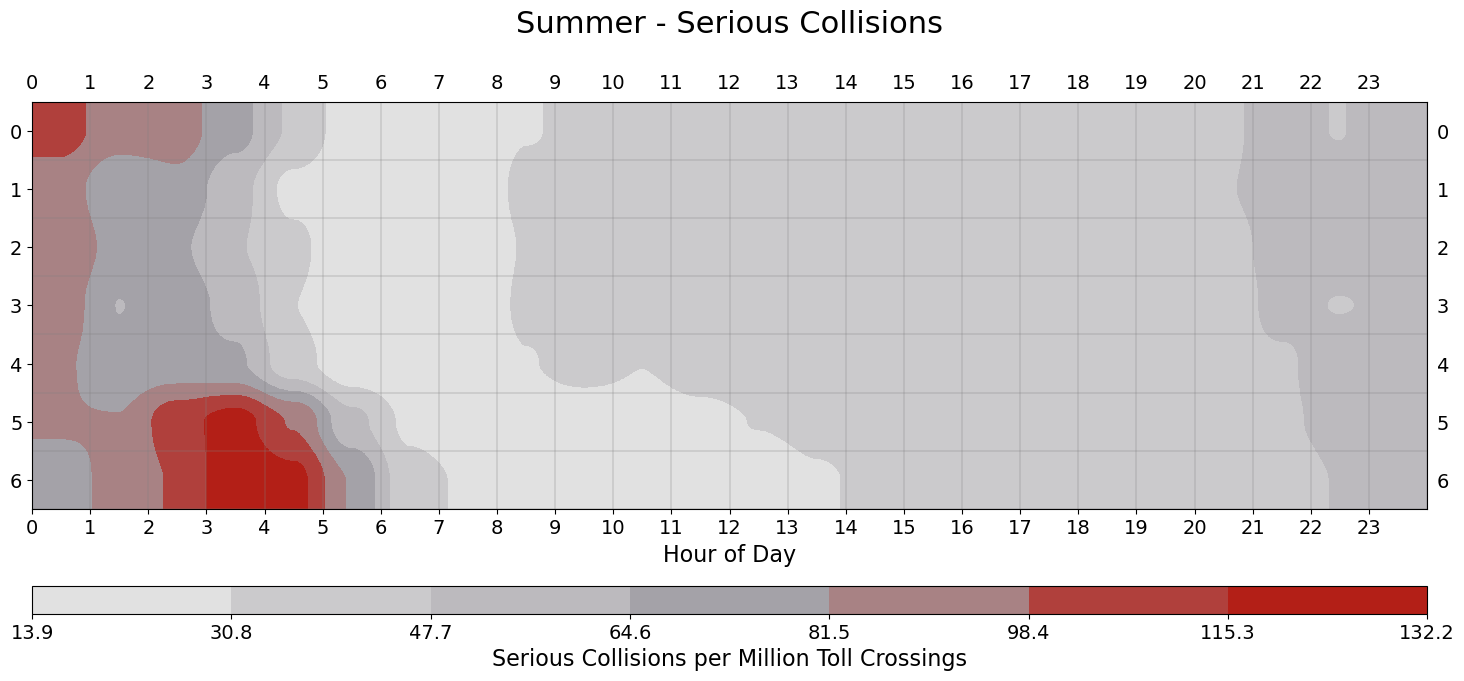

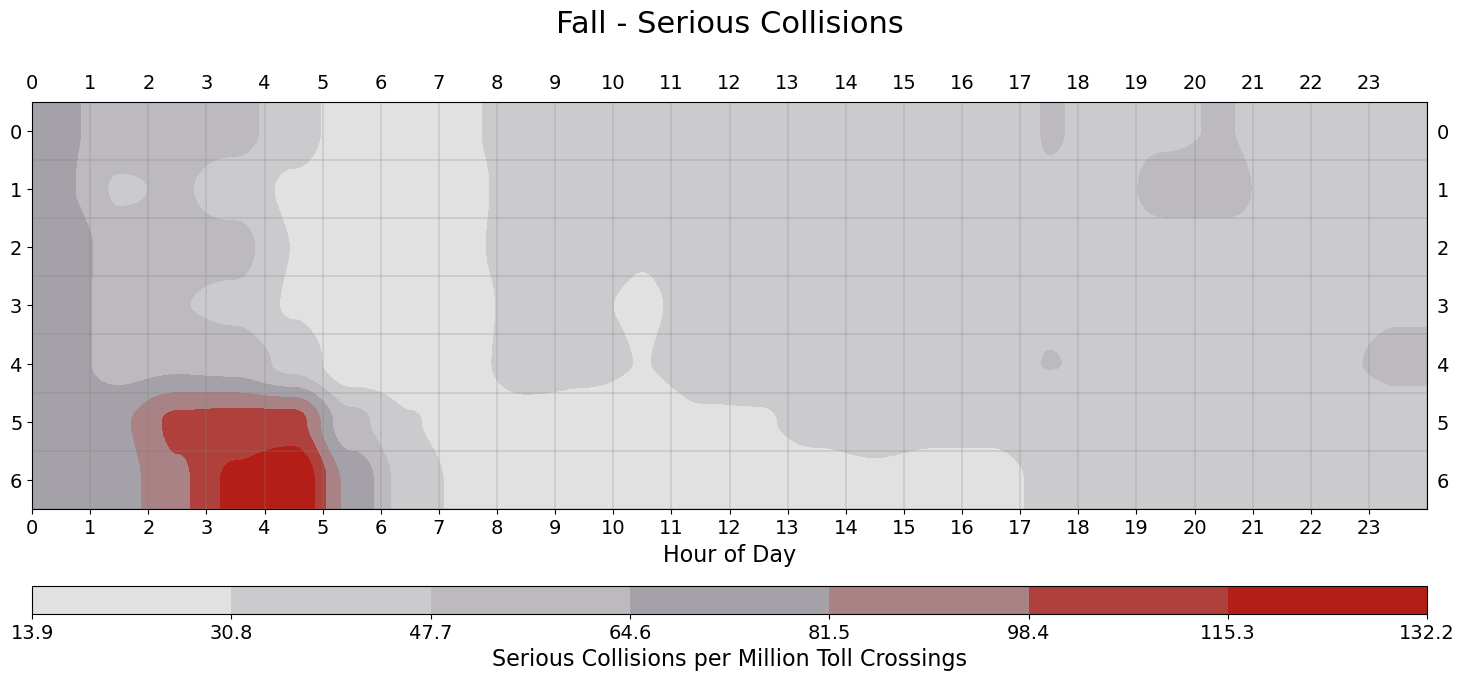

In [41]:
max_val = float("-inf")
min_val = float("inf")
cts = {}
for season in SEASONS:
    season_df = serious[serious["season"] == season]
    season_ct = pd.crosstab(
        index=season_df.index.dayofweek,
        columns=season_df.index.hour,
    )
    crossing_df = mta_crossings[mta_crossings["season"] == season]
    crossing_ct = (
        pd.crosstab(
            index=mta_crossings.index.dayofweek,
            columns=mta_crossings.index.hour,
            values=mta_crossings["Sum Vehicles"].values,
            aggfunc="sum",
        )
        / MILLION
    )
    norm_ct = season_ct / crossing_ct
    cts[season] = norm_ct
    min_val = min(min_val, min(norm_ct.min()))  # ct.min() / max() return pd.Series
    max_val = max(max_val, max(norm_ct.max()))

for season in SEASONS:
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Serious Collisions",
        cbar_label="Serious Collisions per Million Toll Crossings",
    )
    viz.heat_map(
        cts[season],
        season_labels,
        interpolation="hanning",
        min_max=(min_val, max_val),
        cbar_format=lambda tick: f"{tick:.1f}",
        save=os.path.join(IMG_DIR, "trends", f"{season.lower()}_heat_norm_vehicle.png"),
    )

## Weekly Collisions with Pedestrians Through the Seasons

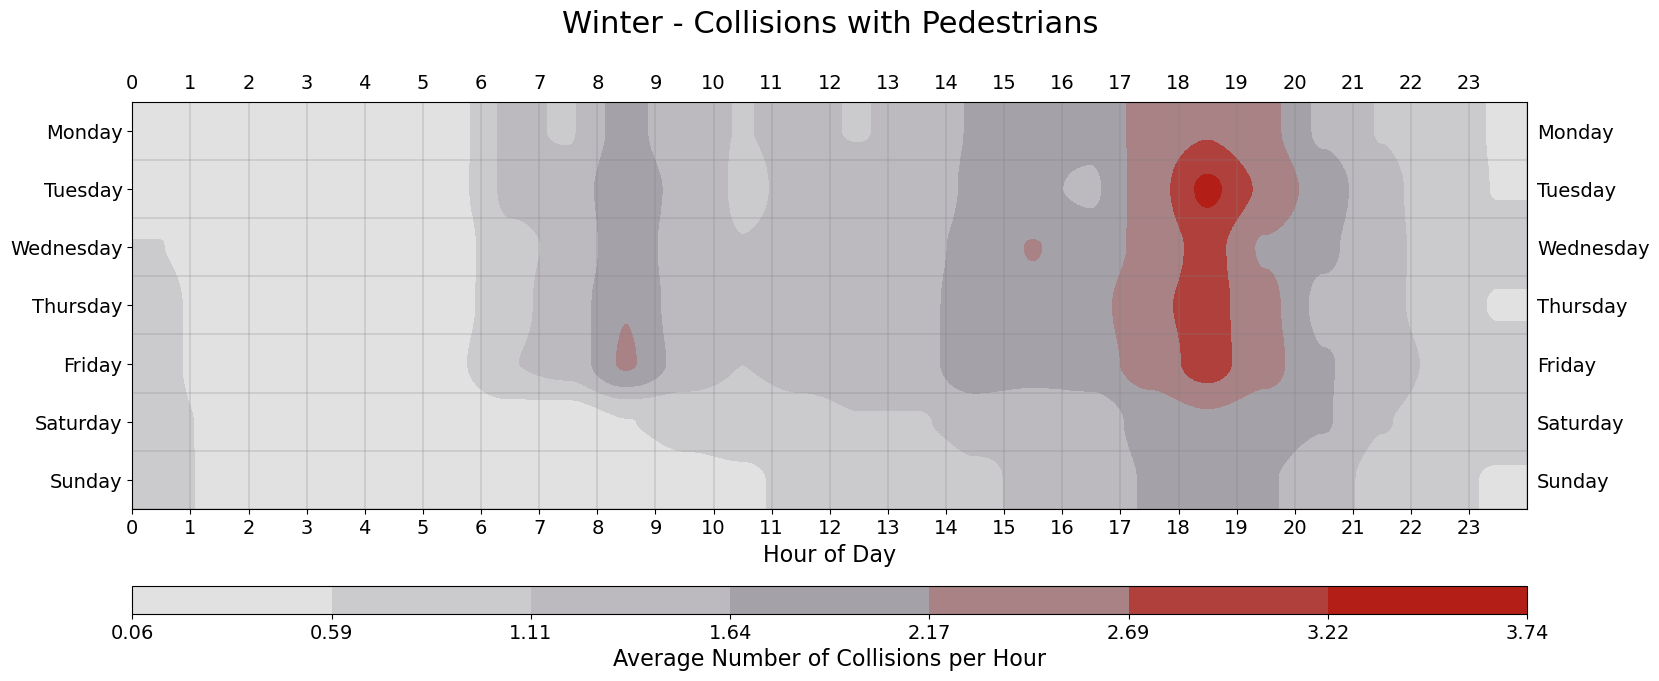

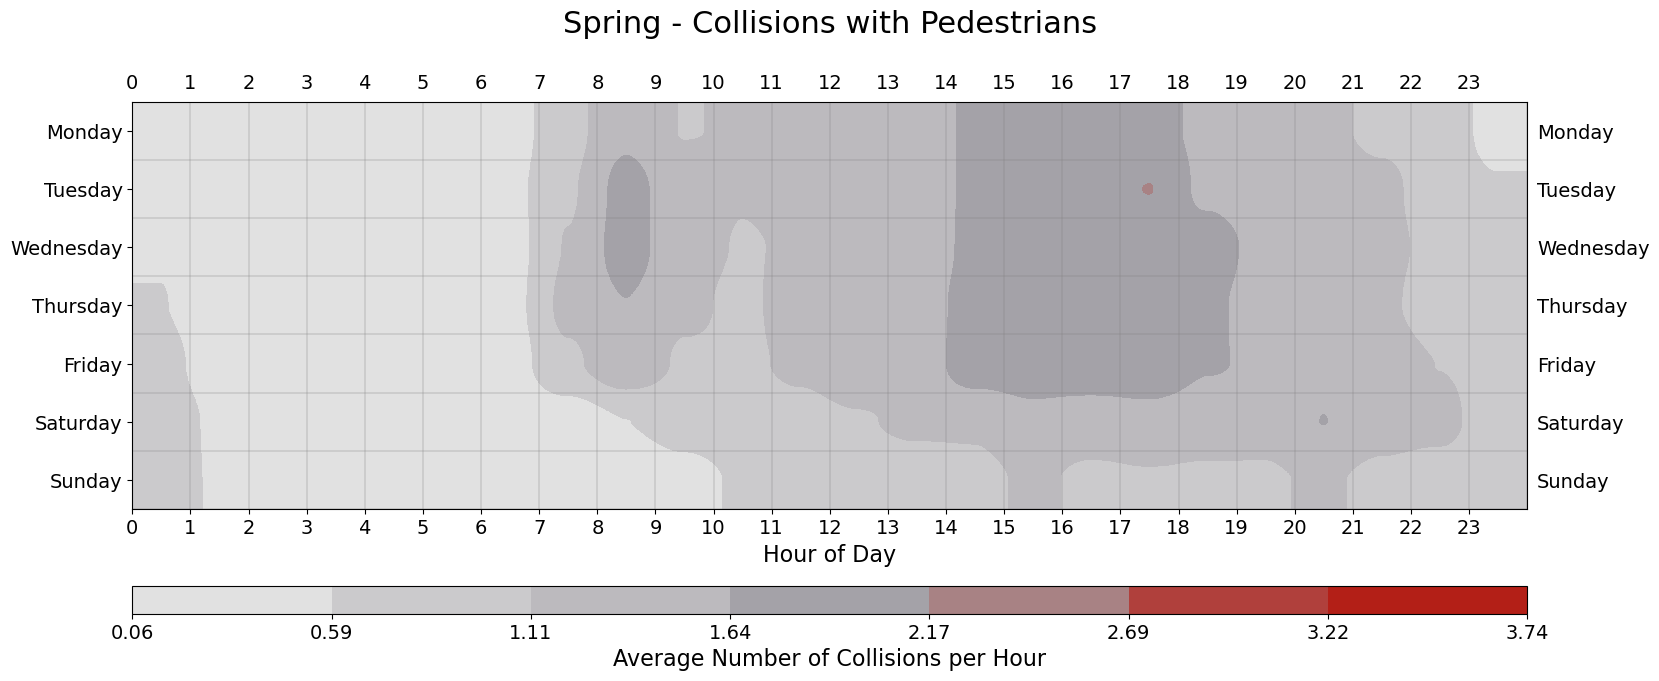

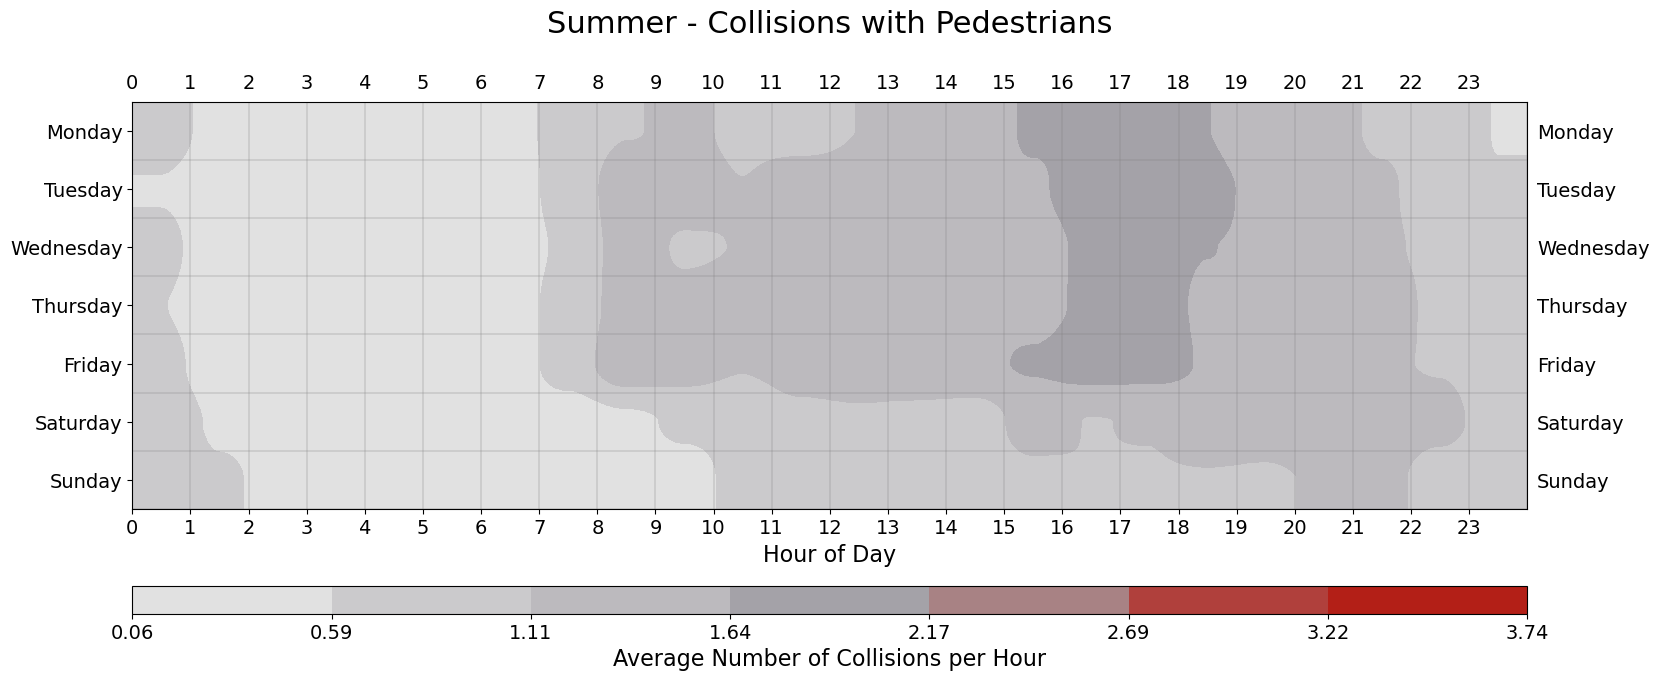

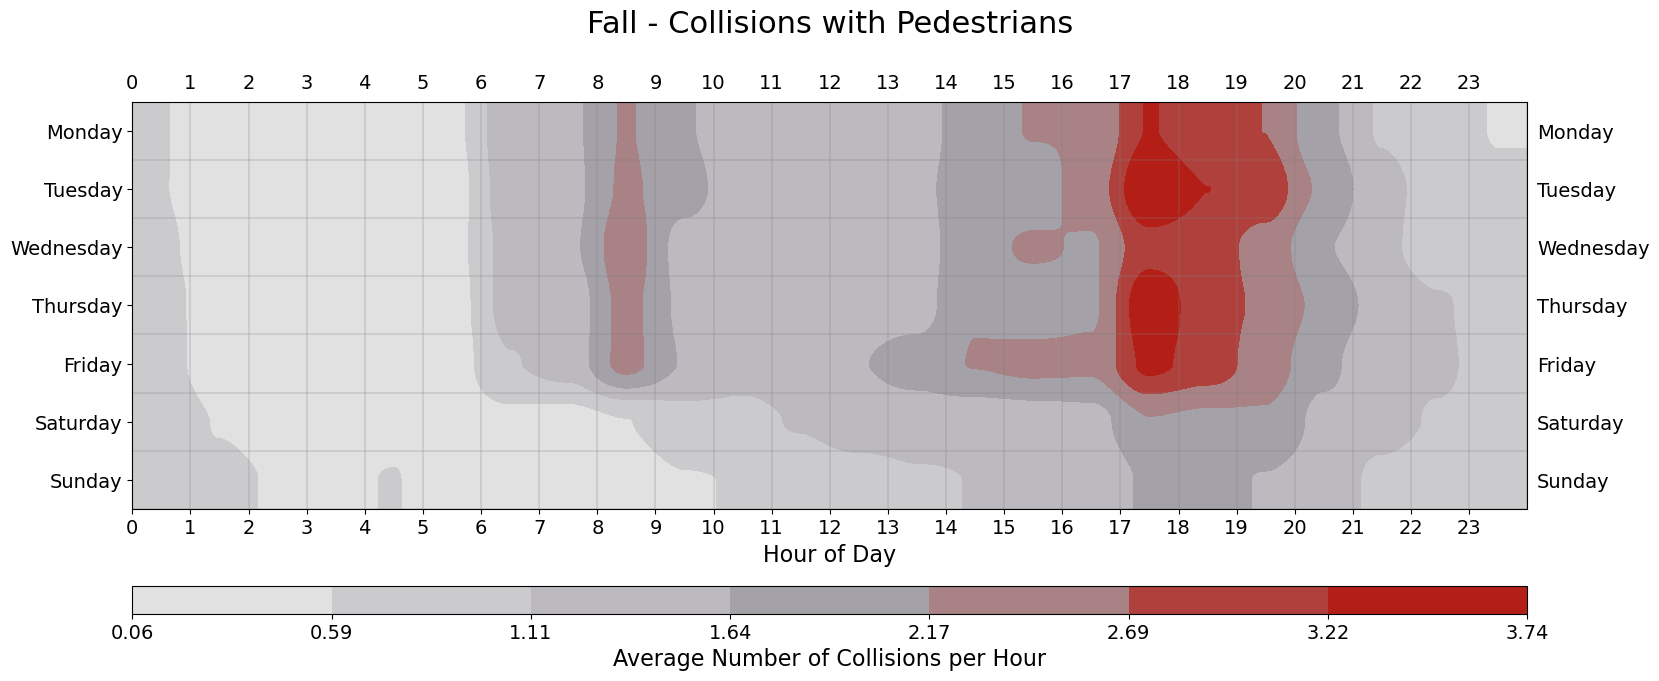

In [42]:
view = serious[serious["pedestrian"]]
mn_mx_serious = src.utils.min_max_across_crosstabs(
    SEASONS,
    view["season"],
    view.index.dayofweek,
    view.index.hour,
    divisor=(total_weeks / 4),
)
for season in SEASONS:
    season_df = view[view["season"] == season]
    season_ct = pd.crosstab(
        index=season_df.index.dayofweek,
        columns=season_df.index.hour,
    )
    season_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Collisions with Pedestrians",
        cbar_label="Average Number of Collisions per Hour",
    )
    viz.heat_map(
        season_ct / (total_weeks / 4),
        season_labels,
        interpolation="hanning",
        min_max=mn_mx_serious,
        save=os.path.join(IMG_DIR, f"{season.lower()}_pedestrian_heat.png"),
    )

## Weekly Collisions with Cyclist Through the Seasons

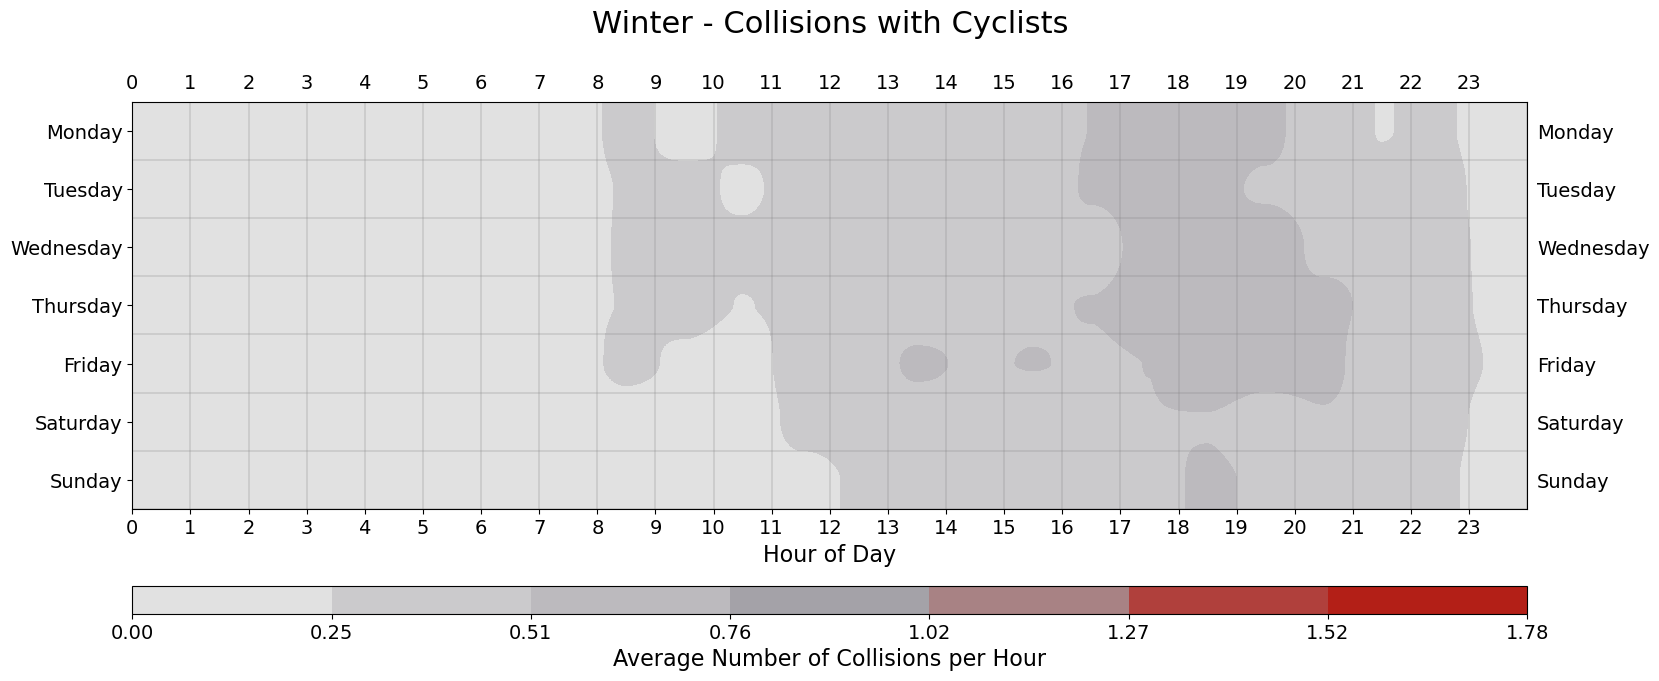

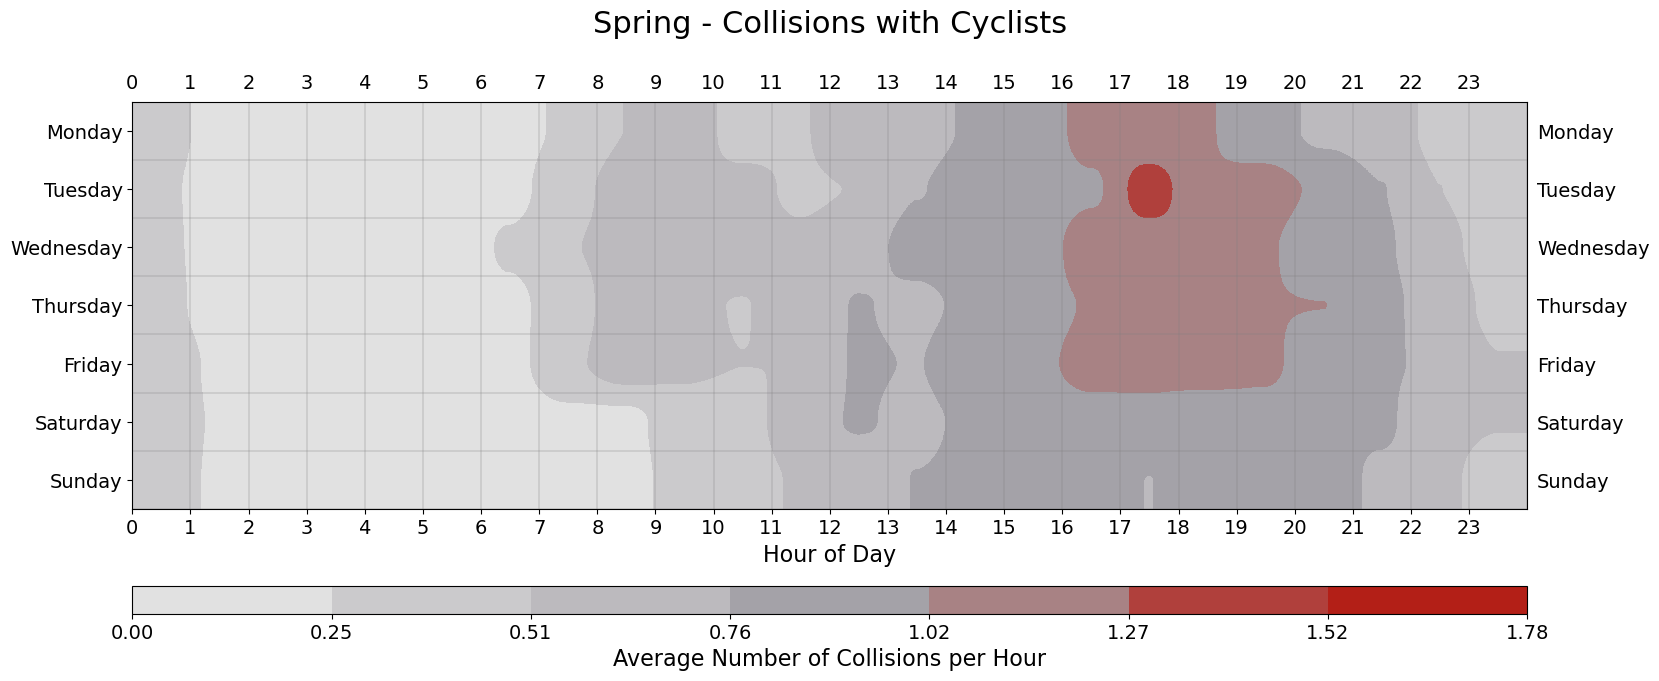

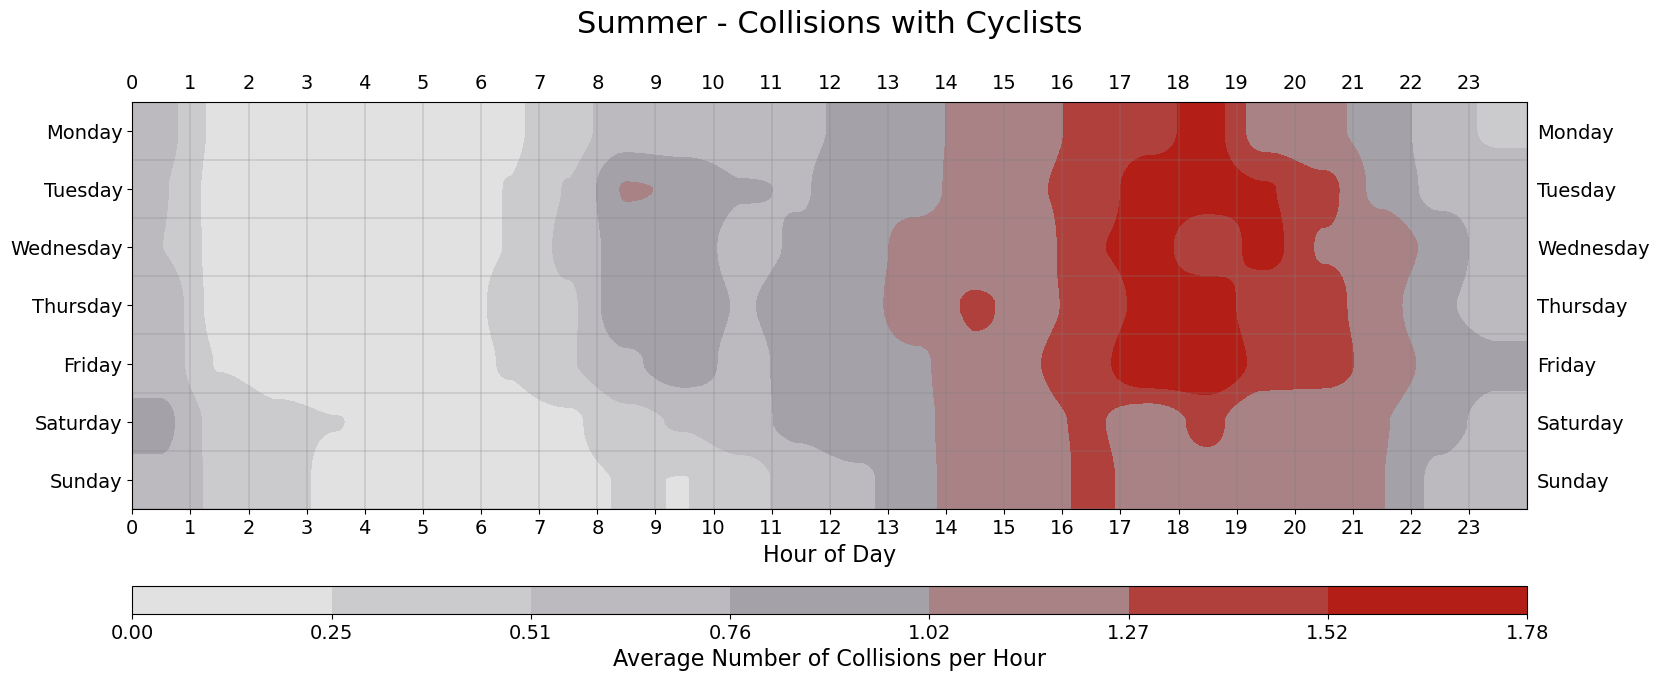

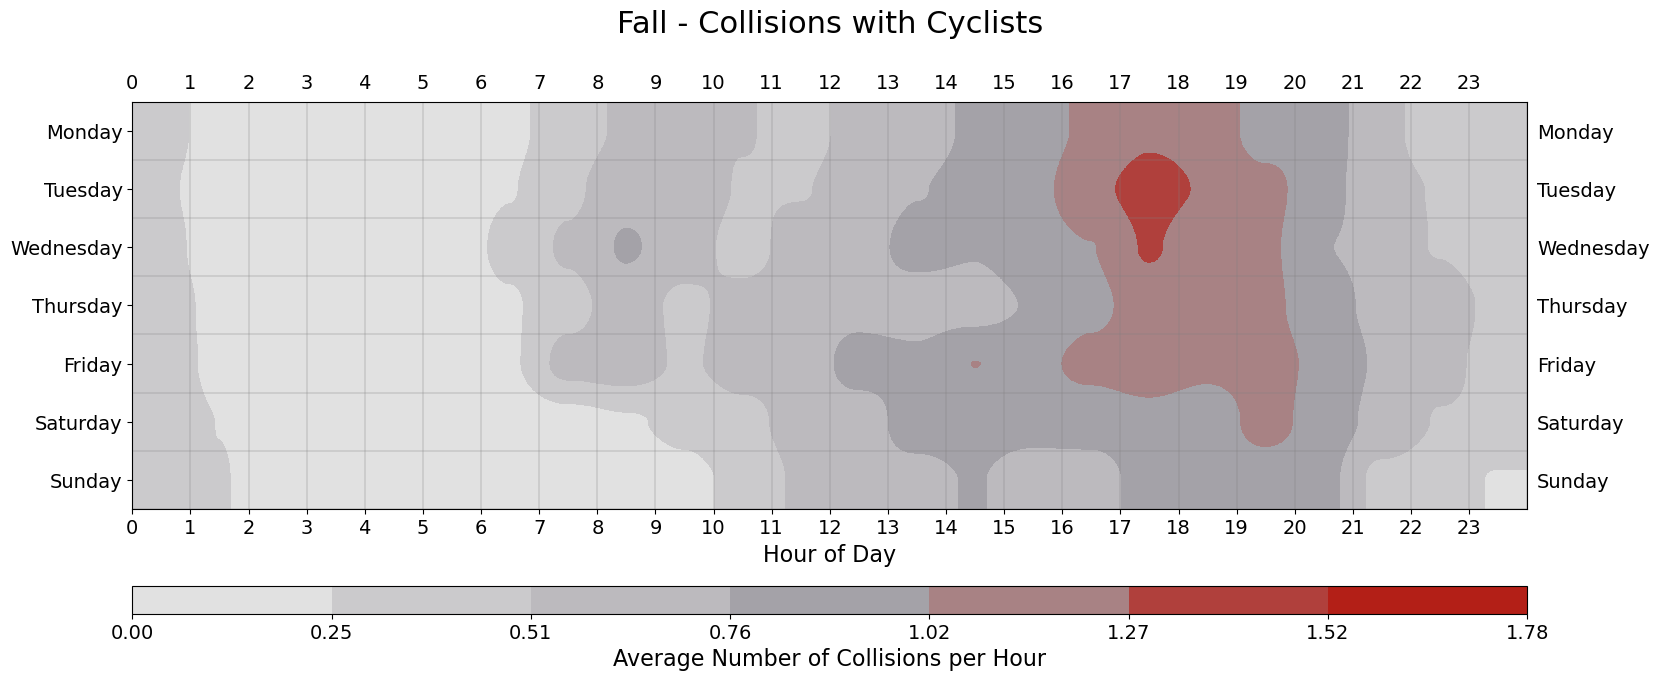

In [43]:
view = serious[serious["cyclist"]]
mn_mx_serious = src.utils.min_max_across_crosstabs(
    SEASONS,
    view["season"],
    view.index.dayofweek,
    view.index.hour,
    divisor=(total_weeks / 4),
)
for season in SEASONS:
    season_df = view[view["season"] == season]
    season_ct = pd.crosstab(
        index=season_df.index.dayofweek,
        columns=season_df.index.hour,
    )
    season_ct.rename(index=DAY_OF_WEEK_MAP, inplace=True)
    season_labels = src.utils.make_heatmap_labels(
        f"{season} - Collisions with Cyclists",
        cbar_label="Average Number of Collisions per Hour",
    )
    viz.heat_map(
        season_ct / (total_weeks / 4),
        season_labels,
        interpolation="hanning",
        min_max=mn_mx_serious,
        save=os.path.join(IMG_DIR, f"{season.lower()}_cyclist_heat.png"),
    )